# Libraries / Shortcuts

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import time
# from nba_api.stats.endpoints.leaguedashplayerbiostats import LeagueDashPlayerBioStats
# from nba_api.stats.endpoints.commonteamroster import CommonTeamRoster
# from nba_api.stats.endpoints.draftcombinedrillresults import DraftCombineDrillResults
# from nba_api.stats.endpoints.draftcombineplayeranthro import DraftCombinePlayerAnthro

seasons = [
    '2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', 
    '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', 
    '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21'
]

# Load Data

## LeagueDashPlayerBioStats

In [180]:
# # https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/commonteamroster.md
# player_bios = []

# for i, season in enumerate(seasons):
#     df_player_bios = LeagueDashPlayerBioStats(season=season).get_data_frames()[0]

#     # Drop unnecessary columns
#     df_player_bios.drop(
#         columns=['PLAYER_HEIGHT'] + list(df_player_bios.columns[-10:]),
#         inplace=True
#     )

#     # Remove underscore in column names, use space instead
#     df_player_bios.columns = [col.replace('_', ' ') for col in df_player_bios.columns]

#     # Creating columns
#     df_player_bios['SEASON'] = season

#     # Print and save progress
#     print('Season {} processed'.format(season))
#     df_player_bios.to_csv('./Data/PlayerBios/PlayerBios_{}.csv'.format(season))

#     player_bios.append(df_player_bios)


# all_player_bios = pd.concat(player_bios, ignore_index=True)

# # Change units
# # Pounds to kilograms
# all_player_bios['PLAYER WEIGHT'] /= 2.20462
# # 1 inch is 2.54 cm, 12 inches per foot
# all_player_bios['PLAYER HEIGHT INCHES'] = 2.54 * all_player_bios['PLAYER HEIGHT INCHES'].astype(float)
# all_player_bios.rename(
#     columns = {
#         'PLAYER HEIGHT INCHES': 'HEIGHT',
#         'PLAYER WEIGHT': 'WEIGHT'
#     },
#     inplace=True
# )

# # Order columns
# new_columns = ['SEASON'] + list(all_player_bios.columns[:-1])
# all_player_bios = all_player_bios[new_columns]

# all_player_bios.sort_values(
#     by=['SEASON', 'TEAM ID'],
#     inplace=True
# )

# all_player_bios.reset_index(drop=True, inplace=True)
# all_player_bios.to_csv('./Data/PlayerBios/all_player_bios.csv')

In [181]:
player_bios = pd.read_csv('./Data/PlayerBios/all_player_bios.csv', index_col=0)
player_bios

,SEASON,PLAYER ID,PLAYER NAME,TEAM ID,TEAM ABBREVIATION,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER
0,2000-01,673,Alan Henderson,1610612737,ATL,28.0,205.74,106.594334,Indiana,USA,1995,1,16
1,2000-01,1950,Andy Panko,1610612737,ATL,23.0,205.74,111.130263,Lebanon Valley,USA,Undrafted,Undrafted,Undrafted
2,2000-01,1510,Brevin Knight,1610612737,ATL,25.0,177.80,77.110795,Stanford,USA,1997,1,16
3,2000-01,1898,Cal Bowdler,1610612737,ATL,24.0,208.28,111.130263,Old Dominion,USA,1999,1,17
4,2000-01,1544,Chris Crawford,1610612737,ATL,26.0,205.74,106.594334,Marquette,USA,1997,2,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9938,2020-21,1630268,Nate Darling,1610612766,CHA,22.0,198.12,90.718582,Delaware,Canada,Undrafted,Undrafted,Undrafted
9939,2020-21,1630208,Nick Richards,1610612766,CHA,23.0,213.36,111.130263,Kentucky,Jamaica,2020,2,42
9940,2020-21,1629023,P.J. Washington,1610612766,CHA,22.0,200.66,104.326369,Kentucky,USA,2019,1,12
9941,2020-21,1626179,Terry Rozier,1610612766,CHA,27.0,185.42,86.182653,Louisville,USA,2015,1,16


## CommonTeamRoster

In [212]:
# # Get team IDs
# from nba_api.stats.static import teams
# # get_teams returns a list of 30 dictionaries, each an NBA team.
# nba_teams_info = teams.get_teams()

# # Build dictionary with team IDs as keys and name of team as values
# nba_teams_names = {}
# for team in nba_teams_info:
#     nba_teams_names[team['id']] = team['full_name']

# # https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/commonteamroster.md

# all_rosters_by_season = []

# for season in seasons:
#     season_rosters = []

#     for i, team_id in enumerate(list(nba_teams_names.keys())):
#         df_roster = CommonTeamRoster(
#             season=season,
#             team_id=team_id
#         ).get_data_frames()[0]

#         # Creating columns
#         df_roster['SEASON'] = season
#         df_roster['TEAM'] = nba_teams_names[team_id]

#         season_rosters.append(df_roster)

#         # Print progress once in a while
#         if (i+1) % 10 == 0:
#             print('Season {} - {} teams processed'.format(season, i+1))

#     all_current_season_rosters = pd.concat(season_rosters, ignore_index=True)
#     all_current_season_rosters.to_csv('./Data/Rosters/Rosters_{}.csv'.format(season))
#     all_rosters_by_season.append(all_current_season_rosters)

#     time.sleep(180)

# all_rosters = pd.concat(all_rosters_by_season, ignore_index=True)

# # Drop unnecessary columns
# all_rosters.drop(
#     columns=['LeagueID', 'NICKNAME', 'PLAYER_SLUG', 'NUM'], 
#     inplace=True
# )

# # Renaming
# all_rosters.rename(
#     columns={'TeamID': 'TEAM ID', 'PLAYER_ID': 'PLAYER ID', 'PLAYER': 'PLAYER NAME', 'BIRTH_DATE': 'BIRTH DATE'},
#     inplace=True
# )

# # Change units
# all_rosters['WEIGHT'] = all_rosters['WEIGHT'].astype(float) / 2.20462
# all_rosters[['HEIGHT (FEET)', 'HEIGHT (INCHES)']] = all_rosters['HEIGHT'].str.split('-', expand=True).astype(float)
# # Convert from total inches to cm (1 inch is 2.54 cm, 12 inches per foot)
# all_rosters['HEIGHT'] = 2.54 * (all_rosters['HEIGHT (INCHES)'] + (12*all_rosters['HEIGHT (FEET)']))
# all_rosters.drop(columns=['HEIGHT (FEET)', 'HEIGHT (INCHES)'], inplace=True)

# # Order columns
# new_columns = list(all_rosters.columns[:2][::-1]) + list(all_rosters.columns[-2:][::-1]) + list(all_rosters.columns[2:-2])
# all_rosters = all_rosters[new_columns]

# all_rosters.sort_values(
#     by=['SEASON', 'TEAM ID'],
#     inplace=True
# )

# all_rosters.reset_index(drop=True, inplace=True)
# all_rosters.to_csv('./Data/Rosters/all_rosters.csv')

In [219]:
players = pd.read_csv('./Data/Rosters/all_rosters.csv', index_col=0)
players

,SEASON,TEAM ID,TEAM,PLAYER ID,PLAYER NAME,POSITION,HEIGHT,WEIGHT,BIRTH DATE,AGE,EXP,SCHOOL
0,2000-01,1610612737,Atlanta Hawks,2035,DerMarr Johnson,F,205.74,91.172175,"MAY 05, 1980",21.0,R,Cincinnati
1,2000-01,1610612737,Atlanta Hawks,1737,Nazr Mohammed,C,208.28,108.862298,"SEP 05, 1977",23.0,2,Kentucky
2,2000-01,1610612737,Atlanta Hawks,1898,Cal Bowdler,F,208.28,111.130263,"MAR 31, 1977",24.0,1,Old Dominion
3,2000-01,1610612737,Atlanta Hawks,1544,Chris Crawford,F,205.74,106.594334,"MAY 13, 1975",26.0,3,Marquette
4,2000-01,1610612737,Atlanta Hawks,1901,Dion Glover,G,195.58,103.419183,"OCT 22, 1978",22.0,1,Georgia Tech
...,...,...,...,...,...,...,...,...,...,...,...,...
9257,2020-21,1610612766,Charlotte Hornets,202330,Gordon Hayward,F,200.66,102.058405,"MAR 23, 1990",31.0,10,Butler
9258,2020-21,1610612766,Charlotte Hornets,1630176,Vernon Carey Jr.,F-C,205.74,122.470086,"FEB 25, 2001",20.0,R,Duke
9259,2020-21,1610612766,Charlotte Hornets,1629023,P.J. Washington,F,200.66,104.326369,"AUG 23, 1998",22.0,1,Kentucky
9260,2020-21,1610612766,Charlotte Hornets,1630268,Nate Darling,G,198.12,90.718582,"AUG 30, 1998",22.0,R,Delaware


## DraftCombineDrillResults

In [184]:
# # https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/draftcombinedrillresults.md
# all_drill_results = []

# for season in seasons:
#     drill_results = DraftCombineDrillResults(season_year=season).get_data_frames()[0]

#     # Creating columns
#     drill_results['SEASON'] = season

#     # Print and save progress
#     print('Season {} processed'.format(season))
#     drill_results.to_csv('./Data/DraftCombine/DrillResults_{}.csv'.format(season))

#     all_drill_results.append(drill_results)


# df_all_drill_results = pd.concat(all_drill_results, ignore_index=True)

# # Drop unnecessary columns
# df_all_drill_results.drop(
#     columns=['FIRST_NAME', 'LAST_NAME'],
#     inplace=True
# )

# # Remove underscore in column names, use space instead
# df_all_drill_results.columns = [col.replace('_', ' ') for col in df_all_drill_results.columns]

# # Order columns
# new_columns = ['SEASON'] + list(df_all_drill_results.columns[:-1])
# df_all_drill_results = df_all_drill_results[new_columns]

# df_all_drill_results.sort_values(
#     by=['SEASON', 'PLAYER NAME'],
#     inplace=True
# )

# df_all_drill_results.reset_index(drop=True, inplace=True)
# df_all_drill_results.to_csv('./Data/DraftCombine/all_drill_results.csv')

In [185]:
all_drill_results = pd.read_csv('./Data/DraftCombine/all_drill_results.csv', index_col=0)
all_drill_results

,SEASON,TEMP PLAYER ID,PLAYER ID,PLAYER NAME,POSITION,STANDING VERTICAL LEAP,MAX VERTICAL LEAP,LANE AGILITY TIME,MODIFIED LANE AGILITY TIME,THREE QUARTER SPRINT,BENCH PRESS
0,2000-01,NaN,12137,A.J. Granger,SF,30.0,34.0,10.73,NaN,3.25,20.0
1,2000-01,NaN,2062,A.J. Guyton,PG-SG,33.0,37.5,10.55,NaN,3.22,9.0
2,2000-01,NaN,2637,Alex Scales,SG-PG,38.5,42.5,10.98,NaN,3.21,10.0
3,2000-01,NaN,2238,Antonis Fotsis,SF,27.0,30.0,11.60,NaN,3.44,2.0
4,2000-01,NaN,12021,Aubrey Reese,PG,31.5,37.5,11.13,NaN,3.25,14.0
...,...,...,...,...,...,...,...,...,...,...,...
1390,2020-21,1630179.0,1630179,Tyrell Terry,PG,30.0,34.0,10.78,2.59,3.28,NaN
1391,2020-21,1628962.0,1628962,Udoka Azubuike,C,37.0,41.0,11.82,3.61,3.23,NaN
1392,2020-21,1630214.0,1630214,Xavier Tillman Sr.,PF-C,26.0,32.5,11.80,3.01,3.49,NaN
1393,2020-21,1630213.0,1630213,Yoeli Childs,PF,34.0,38.5,10.87,2.42,3.22,NaN


## DraftCombinePlayerAnthro

In [186]:
# # https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/draftcombineplayeranthro.md
# all_player_anthro = []

# for season in seasons:
#     player_anthro = DraftCombinePlayerAnthro(season_year=season).get_data_frames()[0]

#     # Creating columns
#     player_anthro['SEASON'] = season

#     # Print and save progress
#     print('Season {} processed'.format(season))
#     player_anthro.to_csv('./Data/DraftCombine/PlayerAnthro_{}.csv'.format(season))

#     all_player_anthro.append(player_anthro)


# df_all_player_anthro = pd.concat(all_player_anthro, ignore_index=True)

# # Drop unnecessary columns
# df_all_player_anthro.drop(
#     columns=['FIRST_NAME', 'LAST_NAME'],
#     inplace=True
# )

# # Remove underscore in column names, use space instead
# df_all_player_anthro.columns = [col.replace('_', ' ') for col in df_all_player_anthro.columns]

# # Order columns
# new_columns = ['SEASON'] + list(df_all_player_anthro.columns[:-1])
# df_all_player_anthro = df_all_player_anthro[new_columns]

# df_all_player_anthro.sort_values(
#     by=['SEASON', 'PLAYER NAME'],
#     inplace=True
# )

# df_all_player_anthro.reset_index(drop=True, inplace=True)
# df_all_player_anthro.to_csv('./Data/DraftCombine/all_player_anthro.csv')

# Player Info

In [3]:
all_players = pd.read_csv('./Data/all_players.csv', index_col=0)
print(all_players.columns, end='\n\n')
all_players

Index(['SEASON', 'PLAYER ID', 'PLAYER NAME', 'TEAM ID', 'TEAM ABBREVIATION',
       'AGE', 'HEIGHT', 'WEIGHT', 'COLLEGE', 'COUNTRY', 'DRAFT YEAR',
       'DRAFT ROUND', 'DRAFT NUMBER', 'TEAM', 'POSITION', 'BIRTH DATE', 'EXP',
       'SCHOOL'],
      dtype='object')



,SEASON,PLAYER ID,PLAYER NAME,TEAM ID,TEAM ABBREVIATION,AGE,HEIGHT,WEIGHT,COLLEGE,COUNTRY,DRAFT YEAR,DRAFT ROUND,DRAFT NUMBER,TEAM,POSITION,BIRTH DATE,EXP,SCHOOL
0,2000-01,673,Alan Henderson,1610612737,ATL,28.0,205.74,106.594334,Indiana,USA,1995,1,16,Atlanta Hawks,F-C,"DEC 02, 1972",5,Indiana
1,2000-01,1510,Brevin Knight,1610612737,ATL,25.0,177.80,77.110795,Stanford,USA,1997,1,16,Atlanta Hawks,G,"NOV 08, 1975",3,Stanford
2,2000-01,1898,Cal Bowdler,1610612737,ATL,24.0,208.28,111.130263,Old Dominion,USA,1999,1,17,Atlanta Hawks,F,"MAR 31, 1977",1,Old Dominion
3,2000-01,1544,Chris Crawford,1610612737,ATL,26.0,205.74,106.594334,Marquette,USA,1997,2,50,Atlanta Hawks,F,"MAY 13, 1975",3,Marquette
4,2000-01,2035,DerMarr Johnson,1610612737,ATL,21.0,205.74,91.172175,Cincinnati,USA,2000,1,6,Atlanta Hawks,F,"MAY 05, 1980",R,Cincinnati
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8984,2020-21,1630268,Nate Darling,1610612766,CHA,22.0,198.12,90.718582,Delaware,Canada,Undrafted,Undrafted,Undrafted,Charlotte Hornets,G,"AUG 30, 1998",R,Delaware
8985,2020-21,1630208,Nick Richards,1610612766,CHA,23.0,213.36,111.130263,Kentucky,Jamaica,2020,2,42,Charlotte Hornets,C,"NOV 29, 1997",R,Kentucky
8986,2020-21,1629023,P.J. Washington,1610612766,CHA,22.0,200.66,104.326369,Kentucky,USA,2019,1,12,Charlotte Hornets,F,"AUG 23, 1998",1,Kentucky
8987,2020-21,1626179,Terry Rozier,1610612766,CHA,27.0,185.42,86.182653,Louisville,USA,2015,1,16,Charlotte Hornets,G,"MAR 17, 1994",5,Louisville


In [190]:
# Only if join is outer

# # Create mapping between team names and abbreviations
# teams_unique = all_players[all_players['TEAM'].isna() == False][['TEAM ABBREVIATION', 'TEAM']].drop_duplicates()[:35]
# team_abb_to_name = pd.Series(teams_unique['TEAM'].values, index=teams_unique['TEAM ABBREVIATION']).to_dict()
# team_abb_to_name['VAN'] = 'Memphis Grizzlies'
# team_name_to_abb = {v: k for k, v in team_abb_to_name.items()}

# # Fill nans with appropriate team info
# # https://stackoverflow.com/questions/34158320/setting-column-equal-to-value-depending-on-another-column-pandas
# all_players.loc[all_players['TEAM ABBREVIATION'].isna(), 'TEAM ABBREVIATION'] = all_players.loc[all_players['TEAM ABBREVIATION'].isna(), 'TEAM'].map(team_name_to_abb)
# all_players.loc[all_players['TEAM'].isna(), 'TEAM'] = all_players.loc[all_players['TEAM'].isna(), 'TEAM ABBREVIATION'].map(team_abb_to_name)

# Age

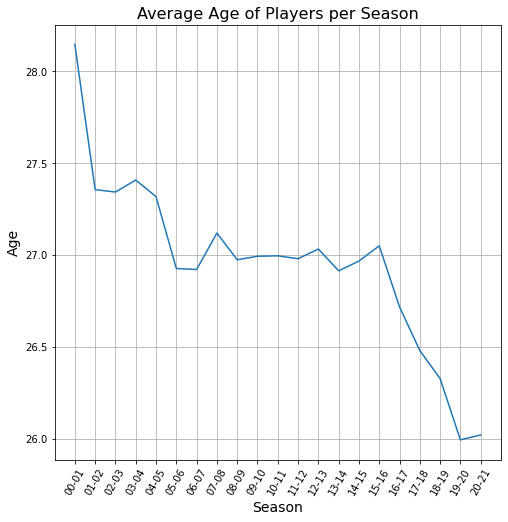

In [16]:
# Average Age by Season
age_by_season = all_players.groupby('SEASON').agg({'AGE': 'mean'})

plt.figure(figsize=(8,8))
plt.title('Average Age of Players per Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Age', fontsize=14)

x_labels = [season[2:] for season in seasons]
plt.tick_params(axis='x', which='major', labelsize=10, rotation=60)
plt.xticks(np.arange(0,21), x_labels)
plt.grid(True)

plt.plot(age_by_season)
plt.show()

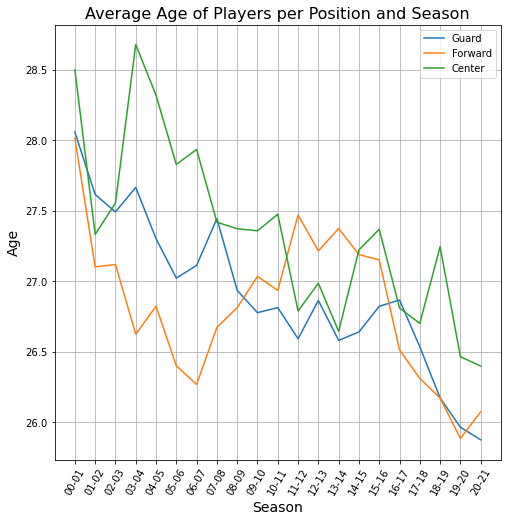

In [29]:
# Average Age by Position and Season (simple version)
# F-C and F-G labeled as F, G-F as G, C-F as C

age_by_position_simple = all_players.copy()
position_meanings = {
    'G': 'Guard',
    'F': 'Forward',
    'C': 'Center'
}

age_by_position_simple['POSITION'] = age_by_position_simple['POSITION'].str.split('-', expand=True)[0]

plt.figure(figsize=(8,8))
plt.title('Average Age of Players per Position and Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Age', fontsize=14)

for position in position_meanings.keys():
    position_data = age_by_position_simple[age_by_position_simple['POSITION'] == position].groupby('SEASON').agg({'AGE': 'mean'})
    plt.plot(position_data, label=position_meanings[position])

x_labels = [season[2:] for season in seasons]
plt.tick_params(axis='x', which='major', labelsize=10, rotation=60)
plt.xticks(np.arange(0,21), x_labels)
plt.grid(True)
plt.legend()
plt.show()

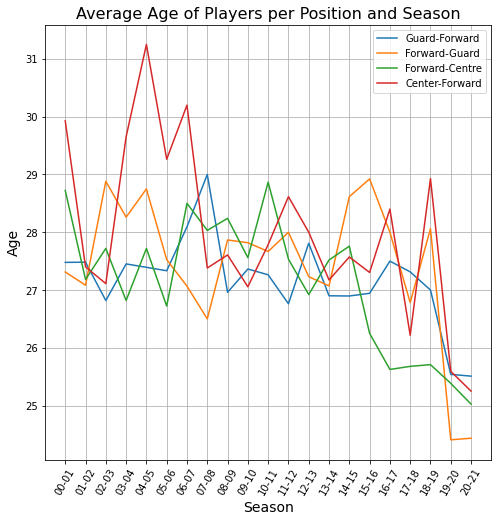

In [31]:
# Average Age by Position and Season (combo players)
# Players that play multiple positions

age_by_position_combo = all_players.copy()
position_meanings = {
    'G-F': 'Guard-Forward',
    'F-G': 'Forward-Guard',
    'F-C': 'Forward-Centre',
    'C-F': 'Center-Forward'
}

plt.figure(figsize=(8,8))
plt.title('Average Age of Players per Position and Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Age', fontsize=14)

for position in position_meanings.keys():
    position_data = age_by_position_combo[age_by_position_combo['POSITION'] == position].groupby('SEASON').agg({'AGE': 'mean'})
    plt.plot(position_data, label=position_meanings[position])

x_labels = [season[2:] for season in seasons]
plt.tick_params(axis='x', which='major', labelsize=10, rotation=60)
plt.xticks(np.arange(0,21), x_labels)
plt.grid(True)
plt.legend()
plt.show()

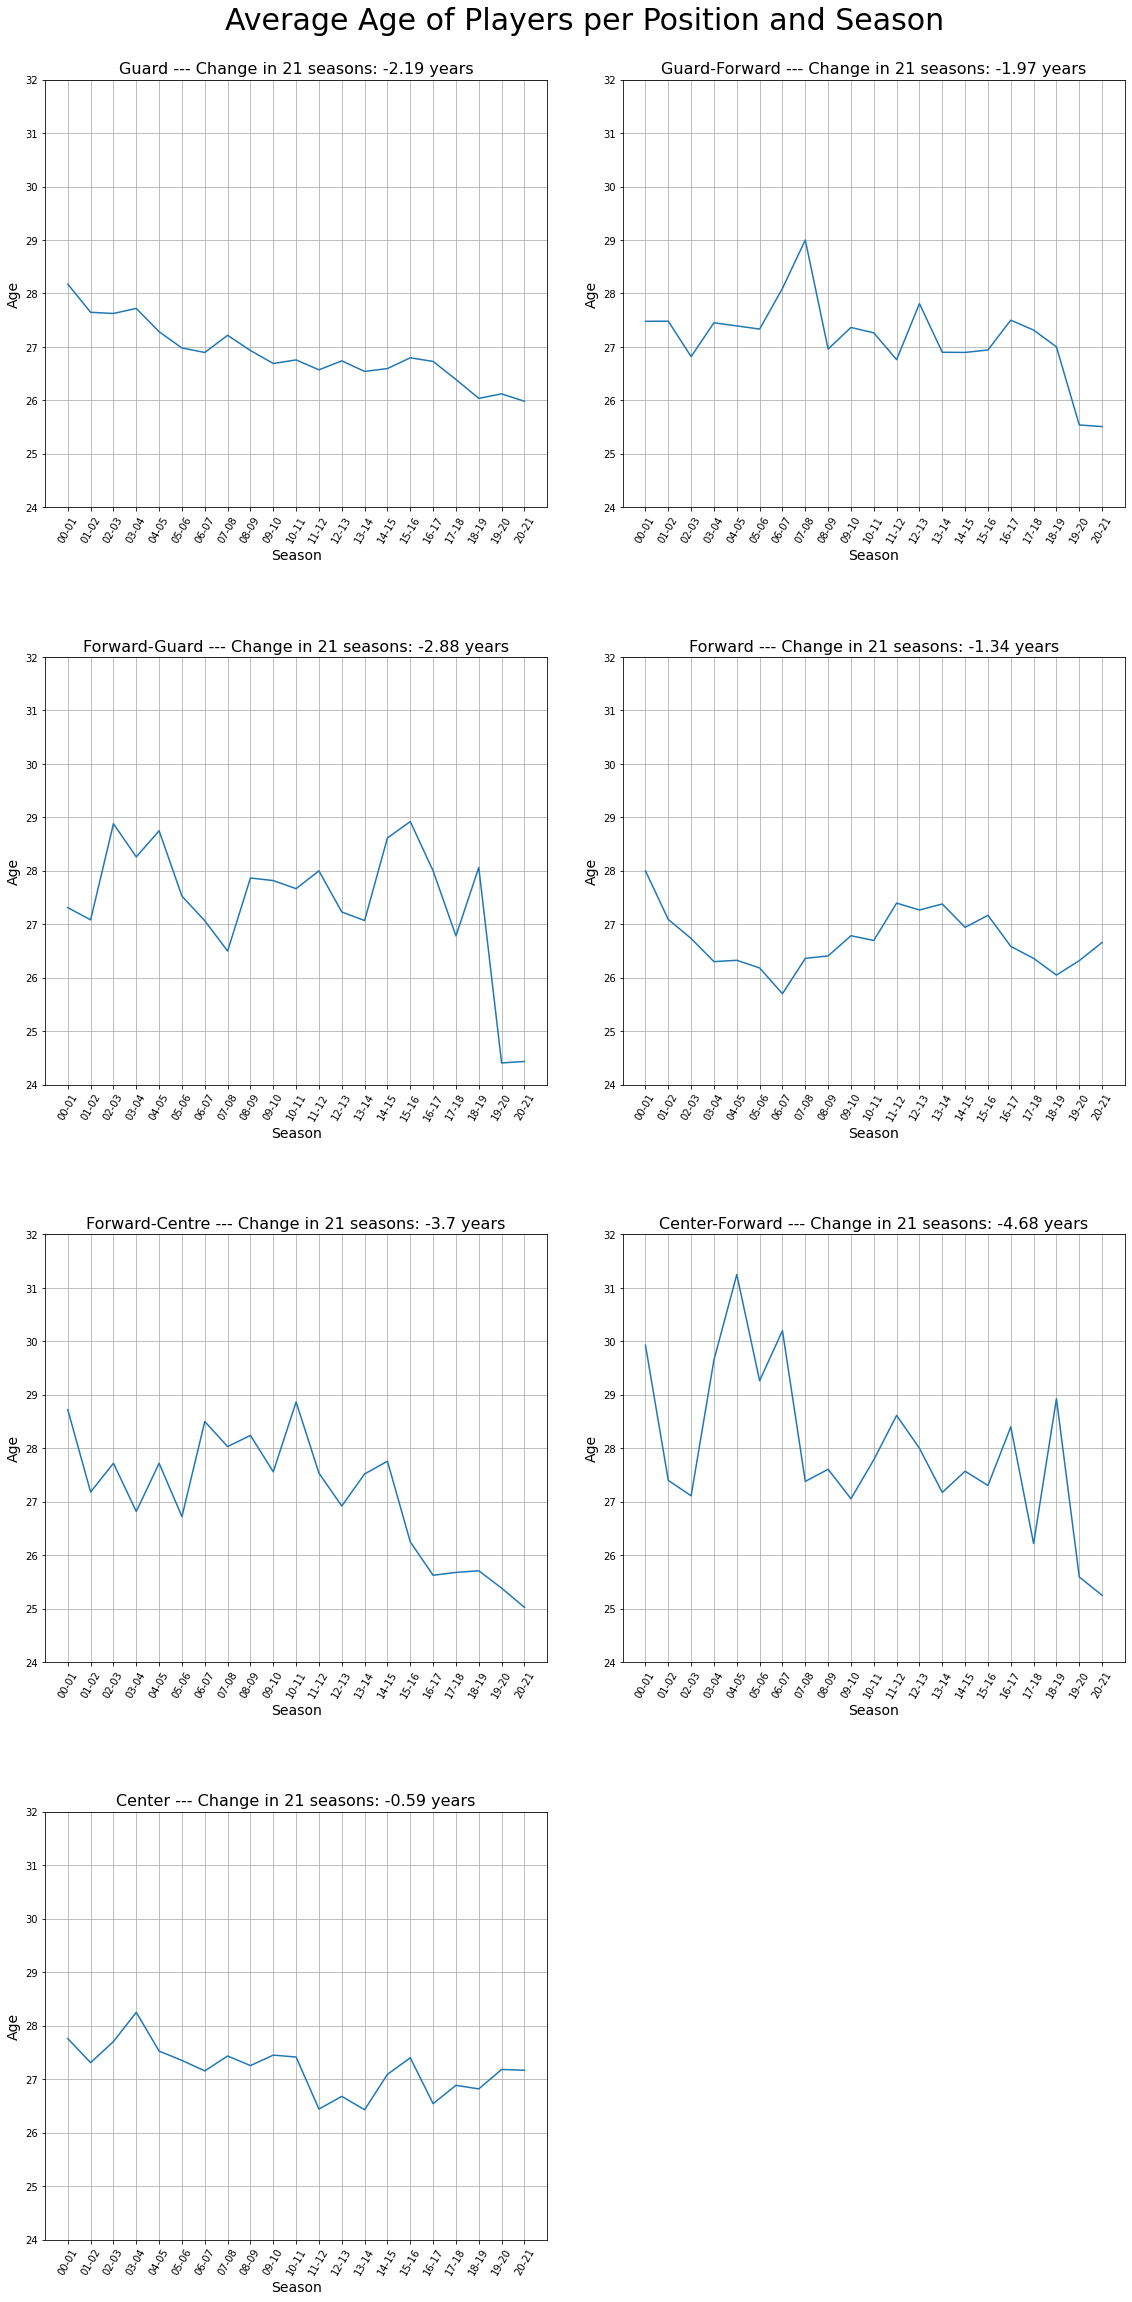

In [80]:
# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['POSITION'].unique())
num_cols = 2
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

position_meanings = {
    'G': 'Guard',
    'G-F': 'Guard-Forward',
    'F-G': 'Forward-Guard',
    'F': 'Forward',
    'F-C': 'Forward-Centre',
    'C-F': 'Center-Forward',
    'C': 'Center'
}

# Plot average ages per position
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Average Age of Players per Position and Season', fontsize=30, pad=50)

k = 0 # Position index

for position in position_meanings.keys():
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    

    k += 1 # Update position index
    
    age_for_position = all_players[all_players['POSITION'] == position].groupby('SEASON').agg({'AGE': 'mean'})
    ax.plot(age_for_position)

    age_difference = round(age_for_position['AGE'][-1] - age_for_position['AGE'][0], 2)
    ax.set_title(
        '{} --- Change in 21 seasons: {}{} years'.format(
            position_meanings[position],
            '+' if age_difference > 0 else '',
            age_difference
        ),
        fontsize=16
    )

    plt.xlabel('Season', fontsize=14)
    plt.ylabel('Age', fontsize=14)

    x_labels = [season[2:] for season in seasons]
    plt.xticks(np.arange(0, 21), labels=x_labels)
    plt.yticks(np.arange(24,33))
    ax.tick_params(axis='x', which='major', labelsize=10, rotation=60)    
    ax.grid(True)

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Average Age per Position and Season')
plt.show()

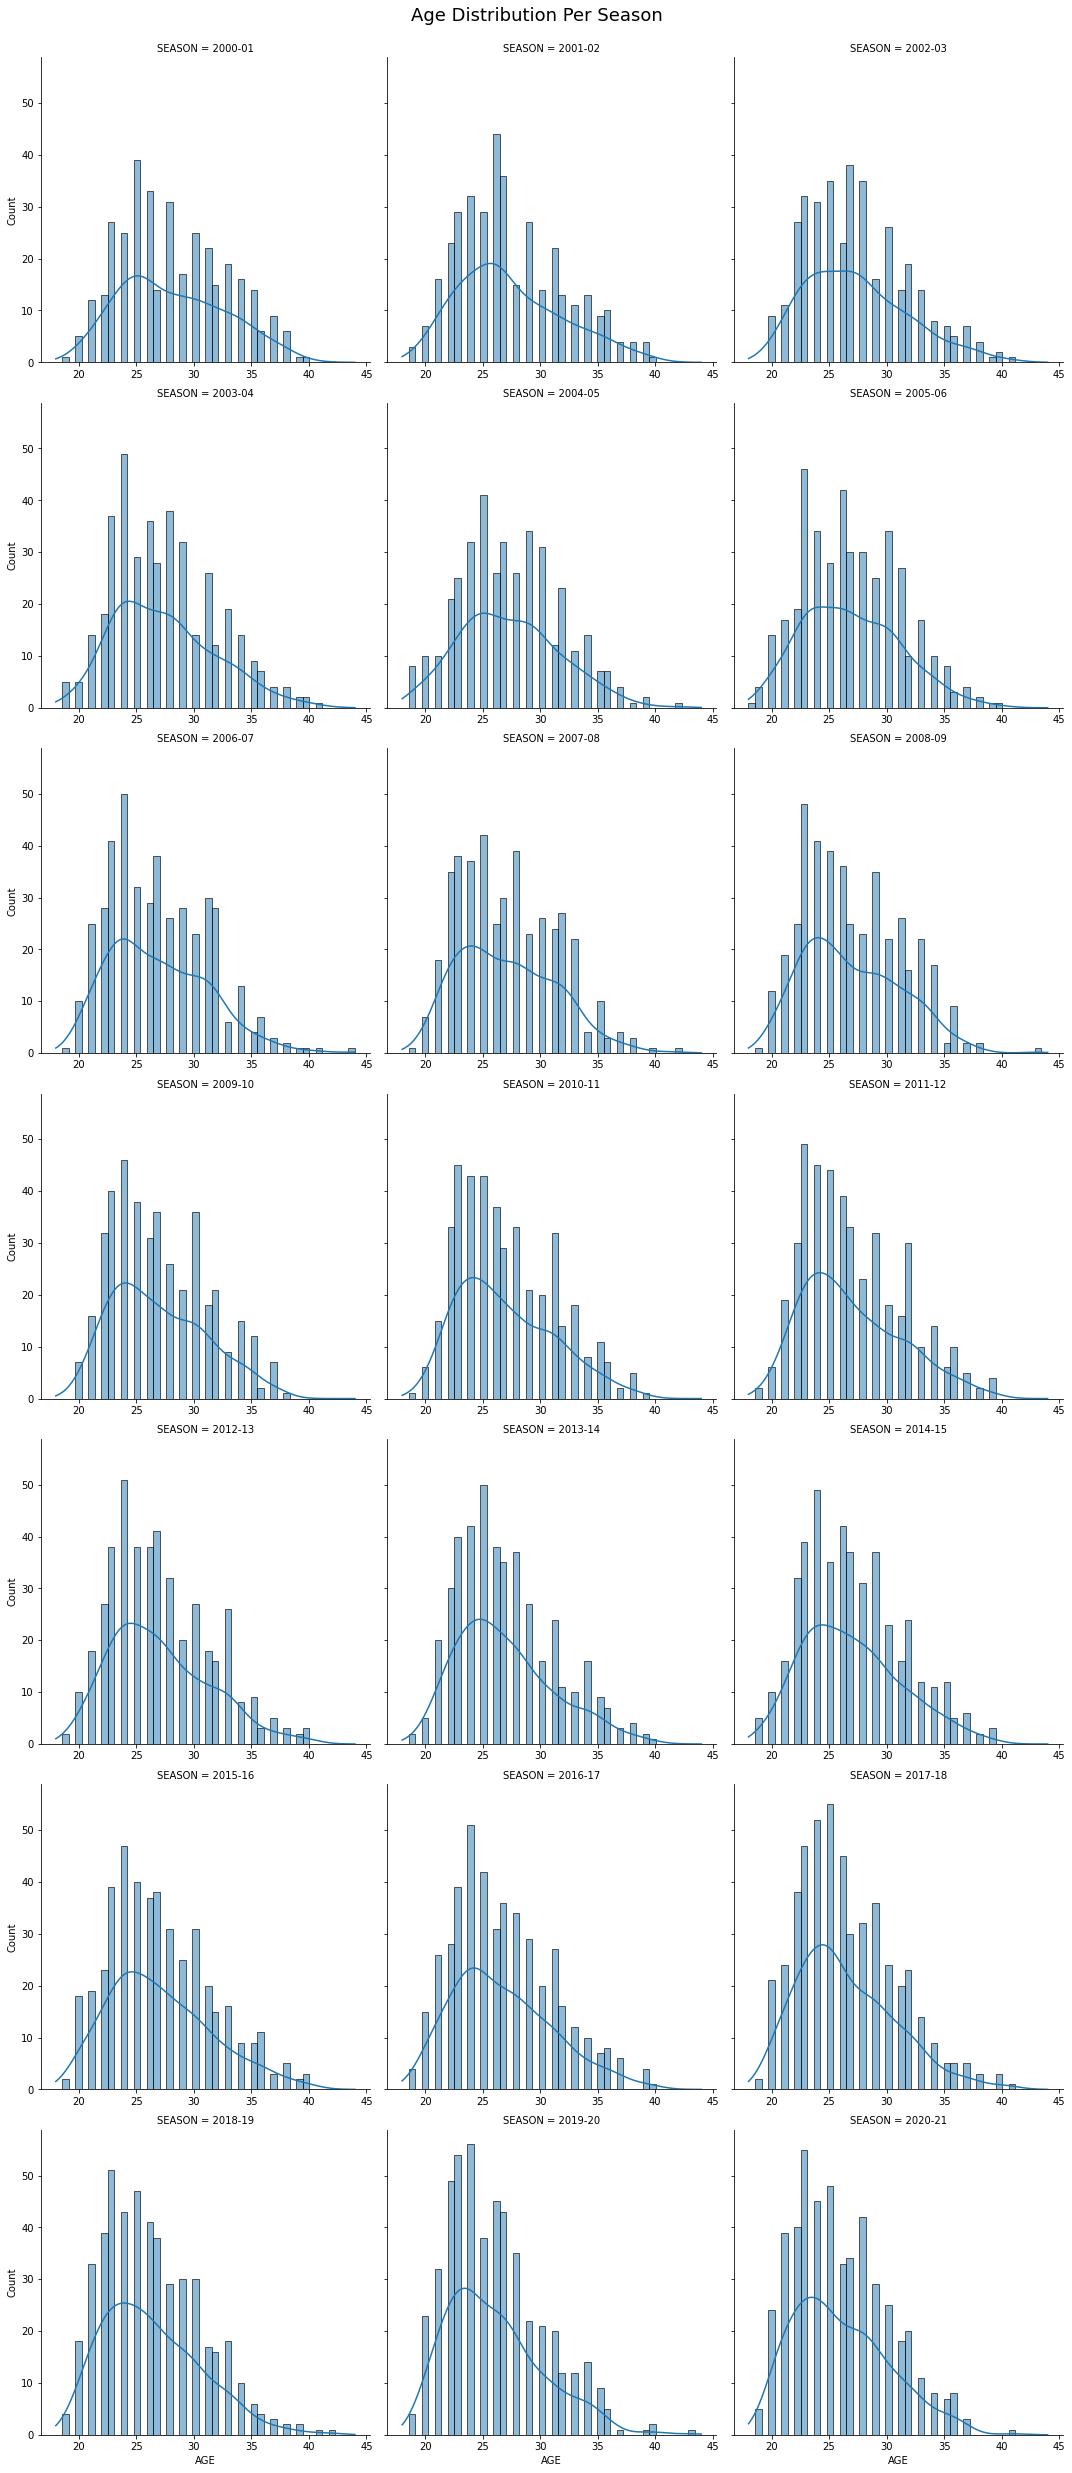

In [14]:
# Age Distributions

ax = sns.displot(
    data = all_players,
    x = 'AGE',
    col = 'SEASON',
    col_wrap = 3,
    kde = True,
    facet_kws = dict(sharex=False)
)

ax.fig.subplots_adjust(top=0.96)
ax.fig.suptitle('Age Distribution Per Season', fontsize=18)

plt.savefig('./Graphs/Players/Age Distribution per Season')
plt.show()

# Height

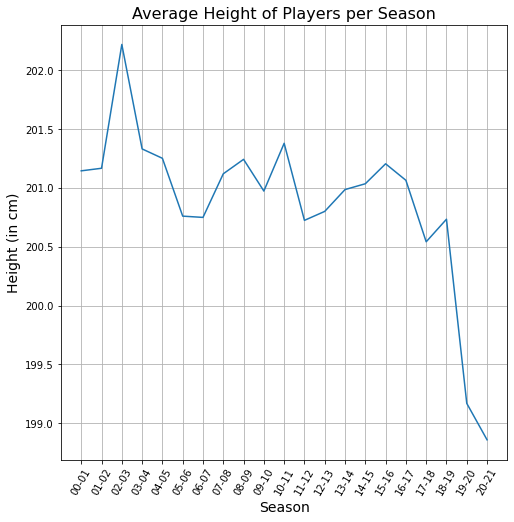

In [7]:
# Average Height per Season
height_per_season = all_players.groupby('SEASON').agg({'HEIGHT': 'mean'})

plt.figure(figsize=(8,8))
plt.title('Average Height of Players per Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Height (in cm)', fontsize=14)

x_labels = [season[2:] for season in seasons]
plt.tick_params(axis='x', which='major', labelsize=10, rotation=60)
plt.xticks(np.arange(0,21), x_labels)
plt.grid(True)

plt.plot(height_per_season)
plt.savefig('./Graphs/Players/Average Height per Season')
plt.show()

# Discuss 'SmallBall'
# https://en.wikipedia.org/wiki/Small_ball_(basketball)

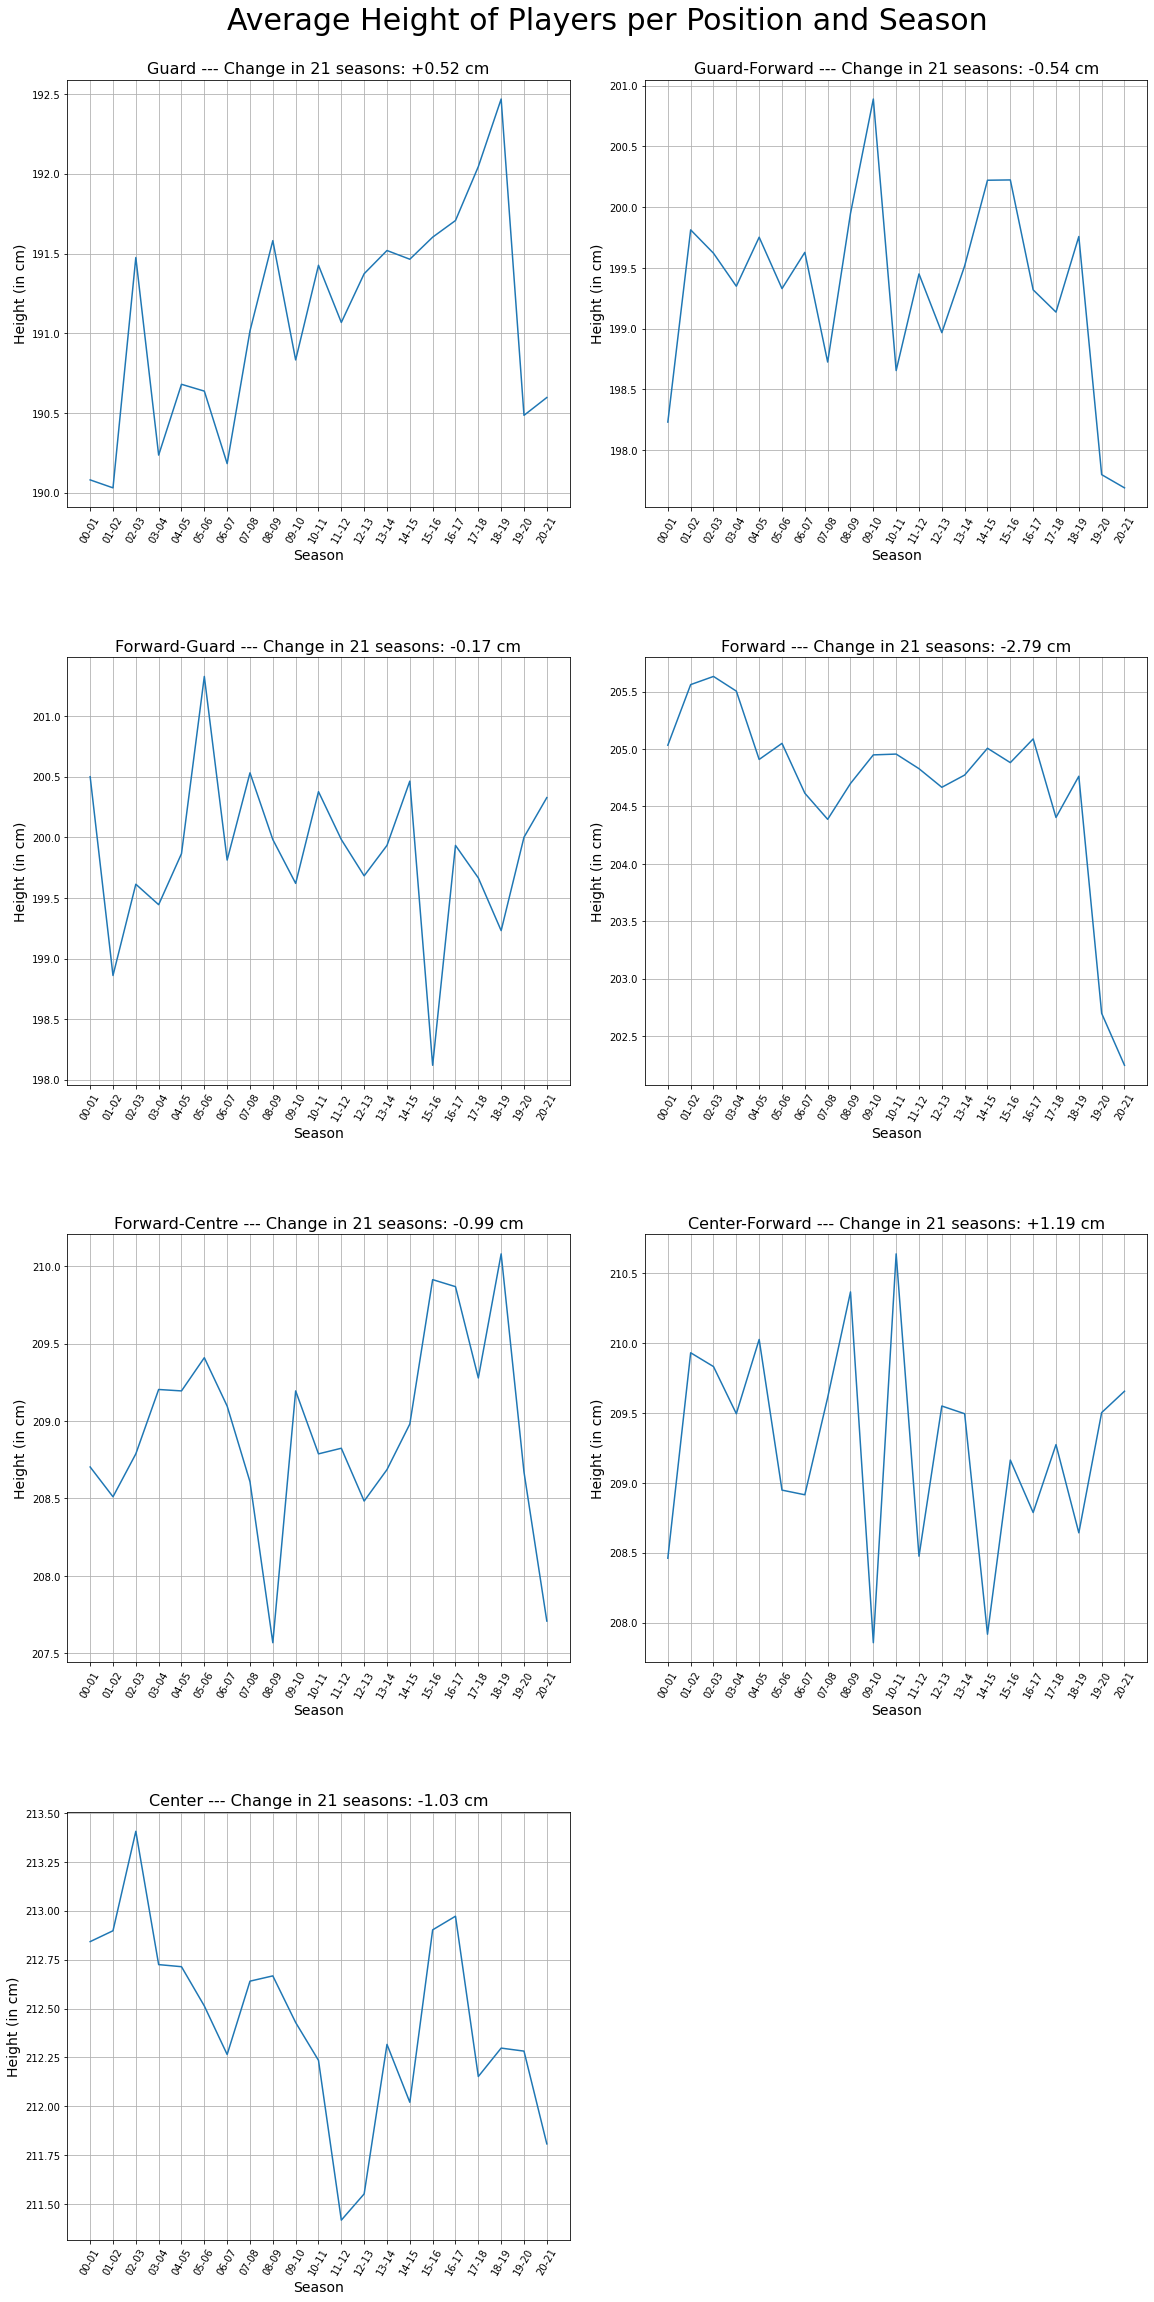

In [3]:
# Average Height per Position and Season

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['POSITION'].unique())
num_cols = 2
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

position_meanings = {
    'G': 'Guard',
    'G-F': 'Guard-Forward',
    'F-G': 'Forward-Guard',
    'F': 'Forward',
    'F-C': 'Forward-Centre',
    'C-F': 'Center-Forward',
    'C': 'Center'
}

# Plot average heights per position
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Average Height of Players per Position and Season', fontsize=30, pad=50)

k = 0 # Position index

for position in position_meanings.keys():
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    

    k += 1 # Update position index
    
    height_for_position = all_players[all_players['POSITION'] == position].groupby('SEASON').agg({'HEIGHT': 'mean'})
    ax.plot(height_for_position)

    height_difference = round(height_for_position['HEIGHT'][-1] - height_for_position['HEIGHT'][0], 2)
    ax.set_title(
        '{} --- Change in 21 seasons: {}{} cm'.format(
            position_meanings[position],
            '+' if height_difference > 0 else '',
            height_difference
        ),
        fontsize=16
    )

    plt.xlabel('Season', fontsize=14)
    plt.ylabel('Height (in cm)', fontsize=14)

    x_labels = [season[2:] for season in seasons]
    plt.xticks(np.arange(0, 21), labels=x_labels)
    ax.tick_params(axis='x', which='major', labelsize=10, rotation=60)    
    ax.grid(True)

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Average Height per Position and Season')
plt.show()

# Weight

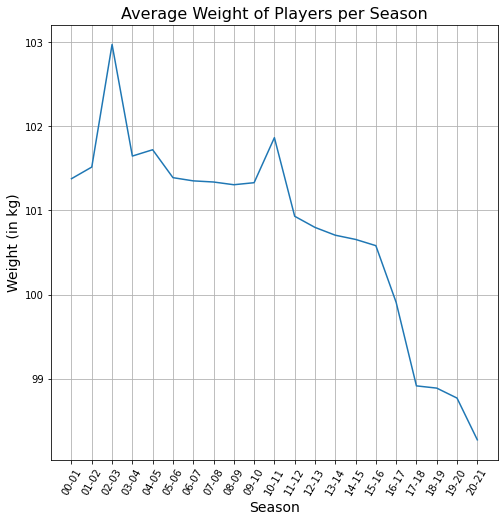

In [4]:
# Average weight per Season
weight_per_season = all_players.groupby('SEASON').agg({'WEIGHT': 'mean'})

plt.figure(figsize=(8,8))
plt.title('Average Weight of Players per Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Weight (in kg)', fontsize=14)

x_labels = [season[2:] for season in seasons]
plt.tick_params(axis='x', which='major', labelsize=10, rotation=60)
plt.xticks(np.arange(0,21), x_labels)
plt.grid(True)

plt.plot(weight_per_season)
plt.savefig('./Graphs/Players/Average Weight per Season')
plt.show()

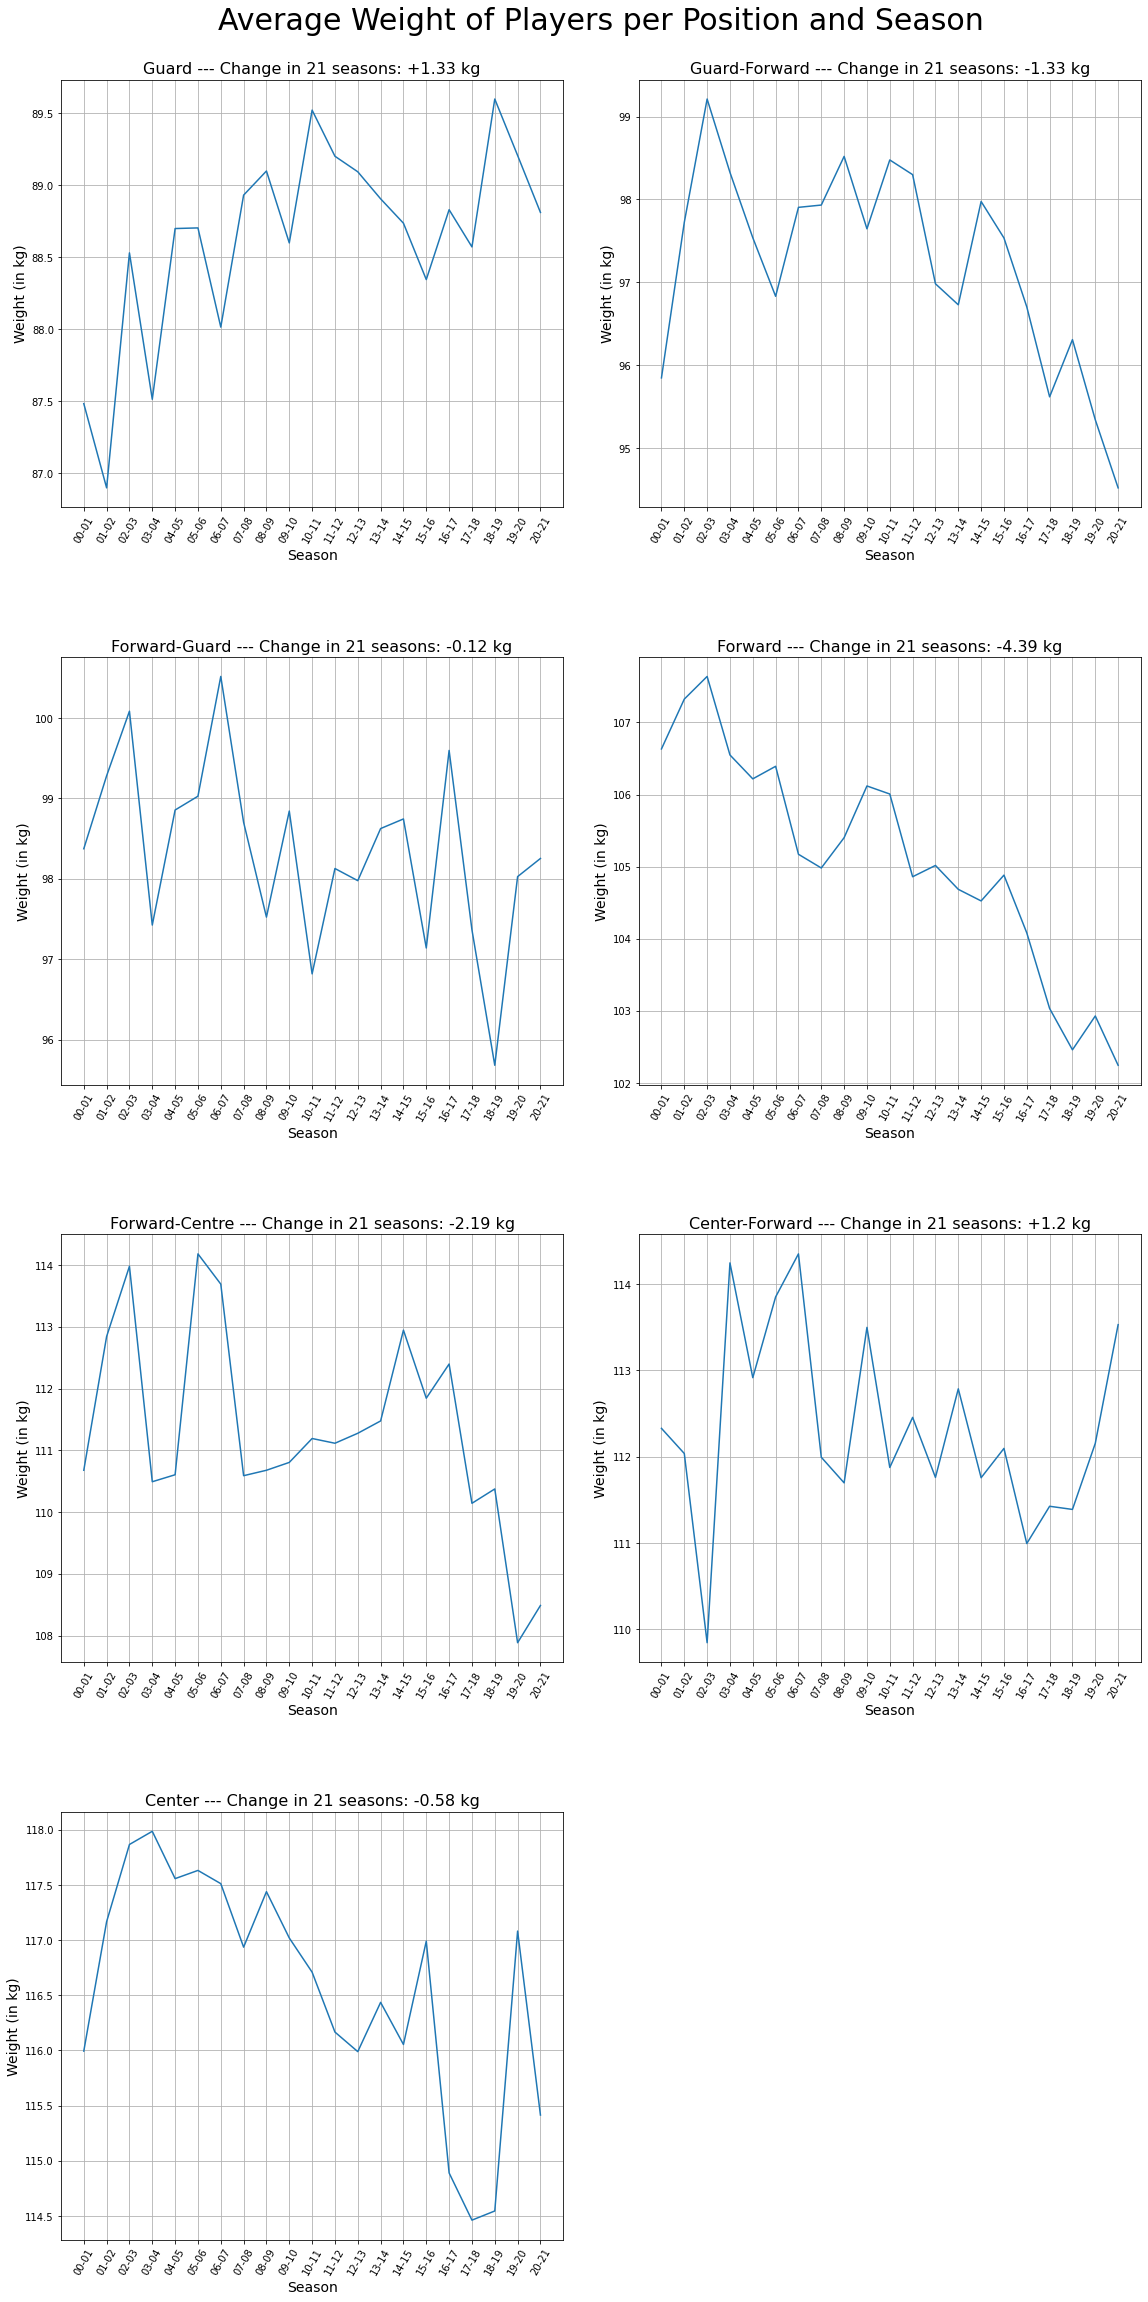

In [5]:
# Average Weight per Position and Season

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['POSITION'].unique())
num_cols = 2
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

position_meanings = {
    'G': 'Guard',
    'G-F': 'Guard-Forward',
    'F-G': 'Forward-Guard',
    'F': 'Forward',
    'F-C': 'Forward-Centre',
    'C-F': 'Center-Forward',
    'C': 'Center'
}

# Plot average weights per position
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Average Weight of Players per Position and Season', fontsize=30, pad=50)

k = 0 # Position index

for position in position_meanings.keys():
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    

    k += 1 # Update position index
    
    weight_for_position = all_players[all_players['POSITION'] == position].groupby('SEASON').agg({'WEIGHT': 'mean'})
    ax.plot(weight_for_position)

    weight_difference = round(weight_for_position['WEIGHT'][-1] - weight_for_position['WEIGHT'][0], 2)
    ax.set_title(
        '{} --- Change in 21 seasons: {}{} kg'.format(
            position_meanings[position],
            '+' if weight_difference > 0 else '',
            weight_difference
        ),
        fontsize=16
    )

    plt.xlabel('Season', fontsize=14)
    plt.ylabel('Weight (in kg)', fontsize=14)

    x_labels = [season[2:] for season in seasons]
    plt.xticks(np.arange(0, 21), labels=x_labels)
    ax.tick_params(axis='x', which='major', labelsize=10, rotation=60)    
    ax.grid(True)

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Average Weight per Position and Season')
plt.show()

## Height-Weight
Study relationship between height and weight

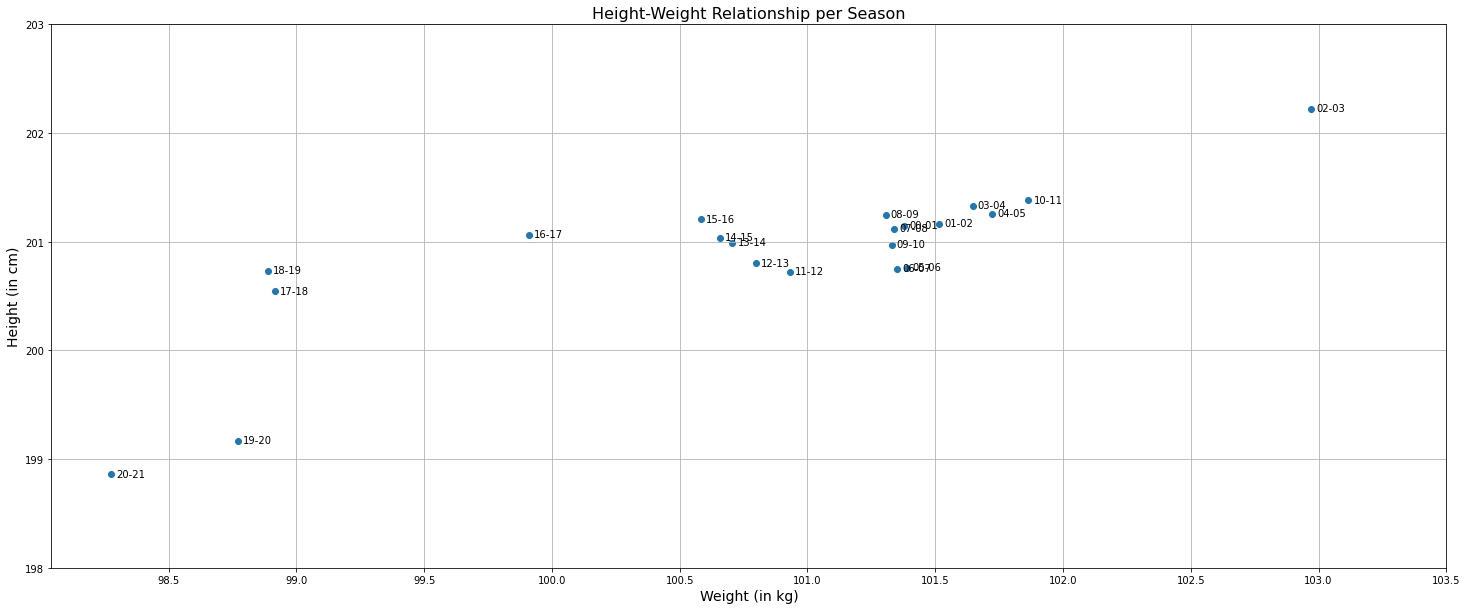

In [55]:
plt.figure(figsize=(25,10))
plt.title('Height-Weight Relationship per Season', fontsize=16)
plt.xlabel('Weight (in kg)', fontsize=14)
plt.ylabel('Height (in cm)', fontsize=14)

plt.scatter(weight_per_season, height_per_season)
plt.xticks(np.arange(int(weight_per_season['WEIGHT'].min()) + 0.5, int(weight_per_season['WEIGHT'].max()) + 2, step=0.5))
plt.yticks(np.arange(int(height_per_season['HEIGHT'].min()), int(height_per_season['HEIGHT'].max()) + 2))
plt.grid(True)

for i, label in enumerate(x_labels):
    plt.annotate(
        text = label,
        xy = (weight_per_season['WEIGHT'][i], height_per_season['HEIGHT'][i]),
        xytext = (weight_per_season['WEIGHT'][i] + 0.02, height_per_season['HEIGHT'][i] - 0.02),
    )

plt.savefig('./Graphs/Players/Height-Weight Relationship')

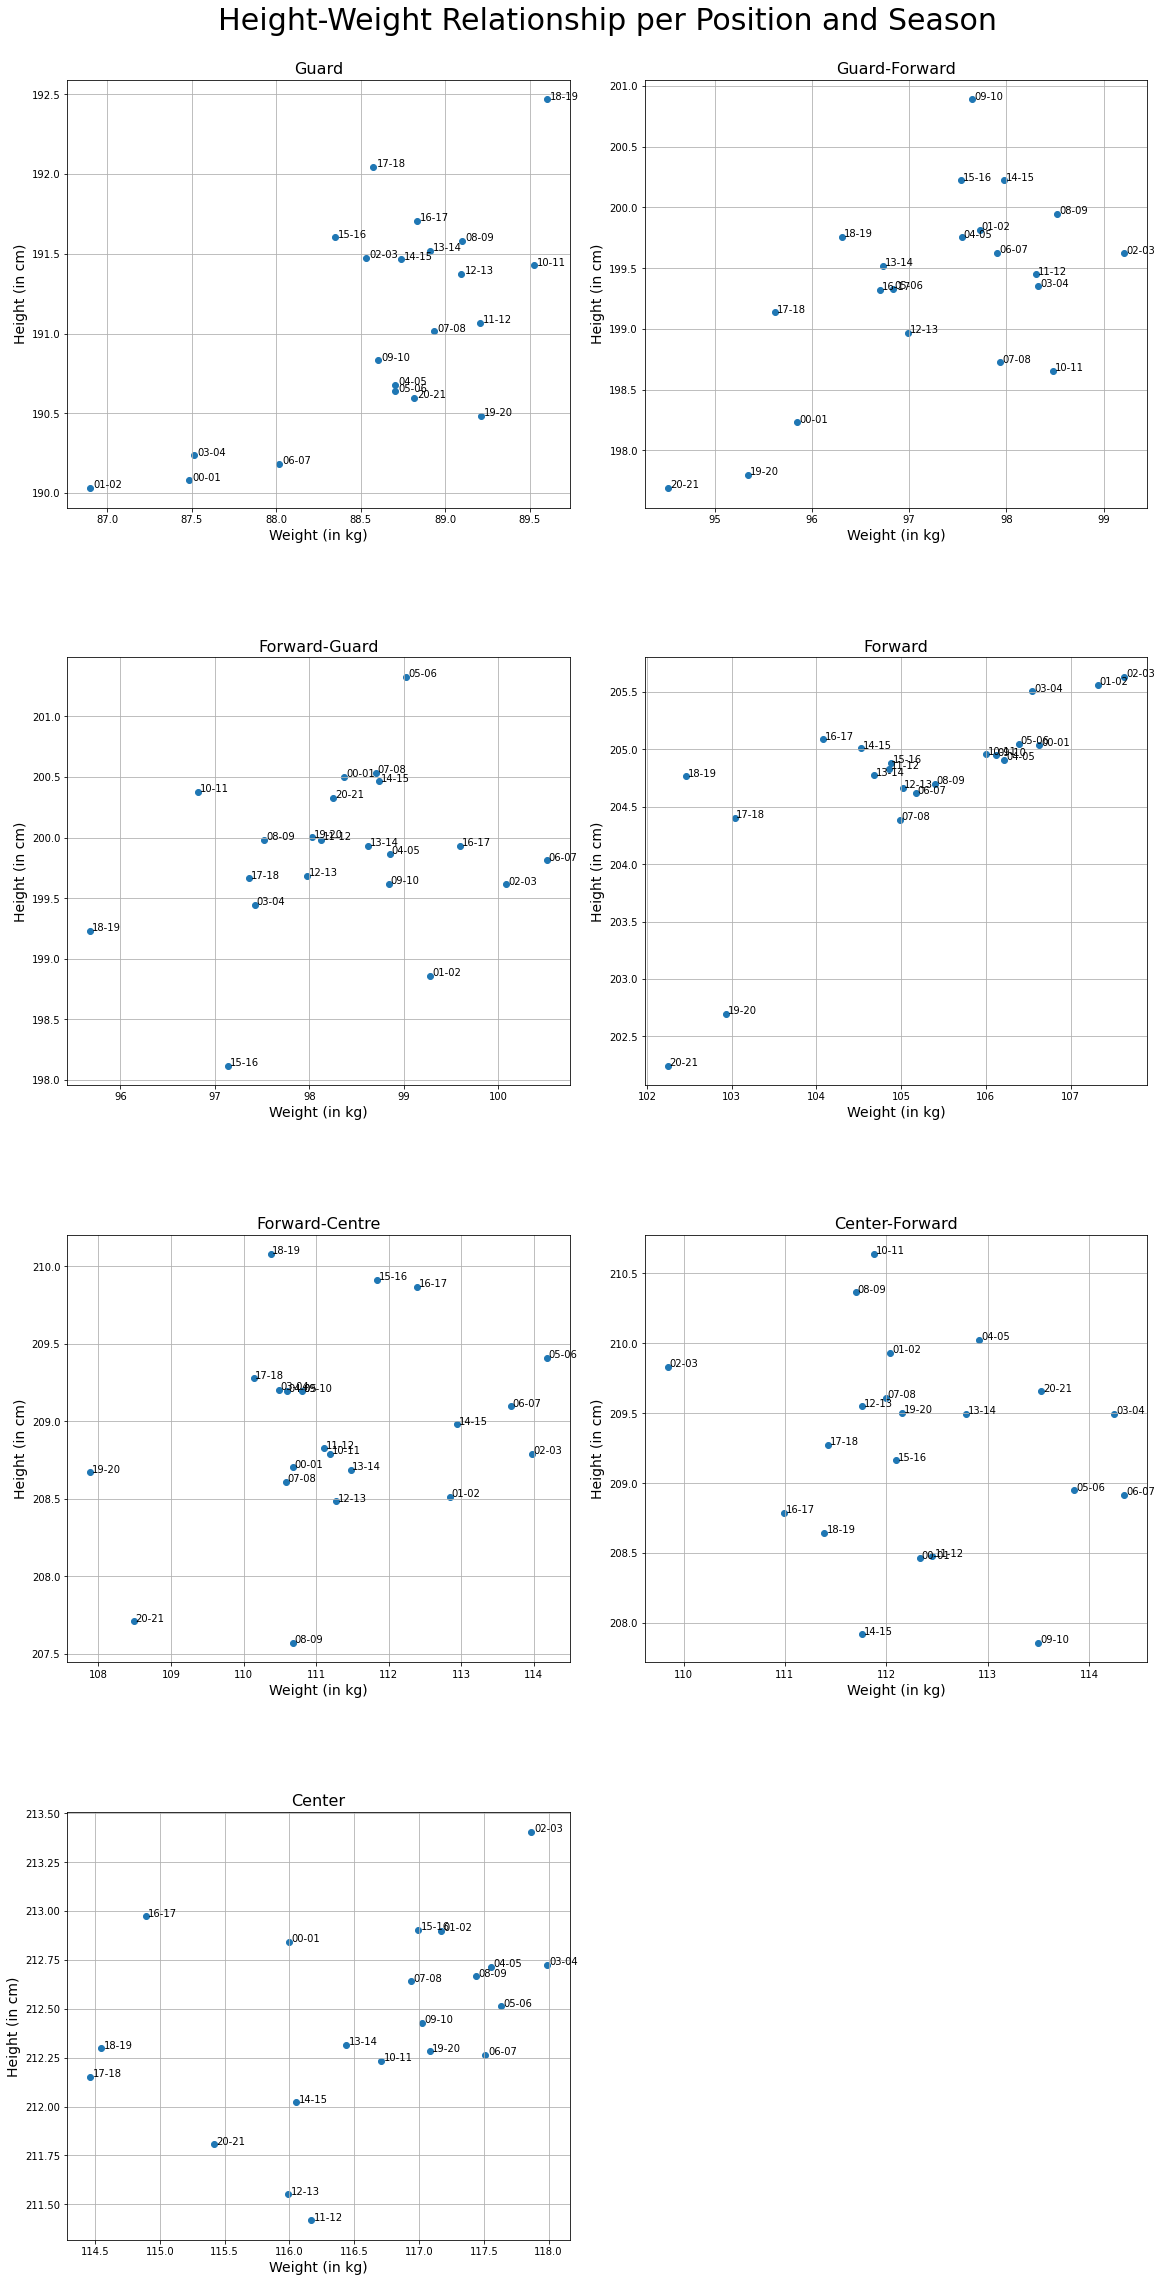

In [56]:
# Height-Weight Relationship per Position and Season

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['POSITION'].unique())
num_cols = 2
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

position_meanings = {
    'G': 'Guard',
    'G-F': 'Guard-Forward',
    'F-G': 'Forward-Guard',
    'F': 'Forward',
    'F-C': 'Forward-Centre',
    'C-F': 'Center-Forward',
    'C': 'Center'
}

# Plot average weights per position
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Height-Weight Relationship per Position and Season', fontsize=30, pad=50)

k = 0 # Position index

for position in position_meanings.keys():
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    ax.set_title(position_meanings[position], fontsize=16)
    plt.xlabel('Weight (in kg)', fontsize=14)
    plt.ylabel('Height (in cm)', fontsize=14)

    k += 1 # Update position index
    
    height_for_position = all_players[all_players['POSITION'] == position].groupby('SEASON').agg({'HEIGHT': 'mean'})
    weight_for_position = all_players[all_players['POSITION'] == position].groupby('SEASON').agg({'WEIGHT': 'mean'})
    plt.scatter(weight_for_position, height_for_position)

    # plt.xticks(np.arange(int(weight_for_position['WEIGHT'].min()), int(weight_for_position['WEIGHT'].max()) + 2))
    # plt.yticks(np.arange(int(height_for_position['HEIGHT'].min()), int(height_for_position['HEIGHT'].max()) + 2))
    ax.grid(True)

    for i, label in enumerate(x_labels):
        ax.annotate(
            text = label,
            xy = (weight_for_position['WEIGHT'][i], height_for_position['HEIGHT'][i]),
            xytext = (weight_for_position['WEIGHT'][i] + 0.02, height_for_position['HEIGHT'][i]),
        )

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Height-Weight Relationship per Position and Season')
plt.show()

In [59]:
# Correlation between height and weight
np.corrcoef(height_per_season['HEIGHT'], weight_per_season['WEIGHT'])

array([[1.        , 0.82384757],
       [0.82384757, 1.        ]])

# College

In [17]:
all_players['COLLEGE'].value_counts()

None                1465
Kentucky             332
Duke                 313
North Carolina       258
UCLA                 233
                    ... 
McNeese State          1
North Texas            1
Westchester C.C.       1
Molloy                 1
Delaware               1
Name: COLLEGE, Length: 269, dtype: int64

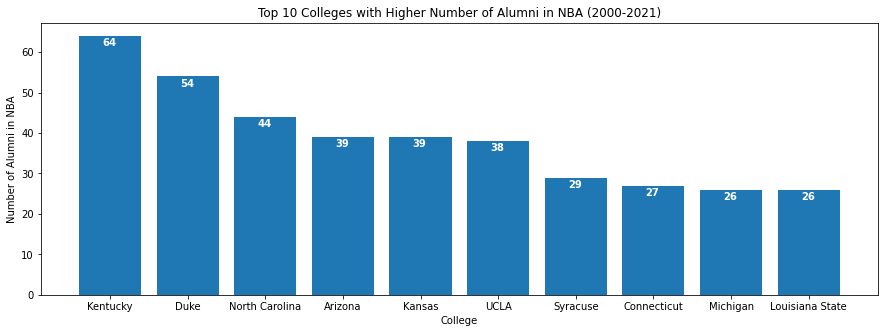

In [74]:
# Show number of (unique) players that made it to the NBA for each 
# college in the top 10 with highest number of alumni in NBA

unique_players = all_players.drop_duplicates('PLAYER ID')
top_10_colleges = unique_players[unique_players['COLLEGE'] != 'None']['COLLEGE'].value_counts()[:10]
plt.figure(figsize=(15,5))
plt.title('Top 10 Colleges with Higher Number of Alumni in NBA (2000-2021)')
plt.xlabel('College')
plt.ylabel('Number of Alumni in NBA')
plt.bar(top_10_colleges.index, top_10_colleges)

for idx, num_alumni in enumerate(top_10_colleges):
    plt.text(idx-0.1, num_alumni-2.5, str(num_alumni), color='w', fontweight='bold')

plt.show()

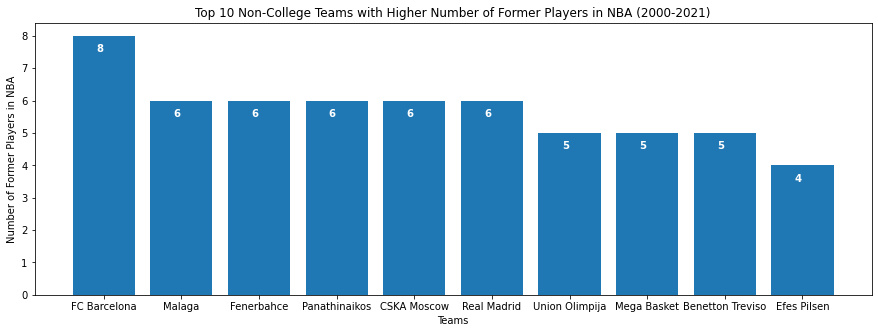

In [99]:
# Show number of (unique) players that made it to the NBA for each 
# non-college in the top 10 with highest number of alumni in NBA

unique_players = all_players.drop_duplicates('PLAYER ID')

# 1 to 11 because 0-index is '' (no team of origin)
top_10_non_colleges = unique_players[unique_players['COLLEGE'] == 'None']['SCHOOL'].value_counts()[1:11]
plt.figure(figsize=(15,5))
plt.title('Top 10 Non-College Teams with Higher Number of Former Players in NBA (2000-2021)')
plt.xlabel('Teams')
plt.ylabel('Number of Former Players in NBA')
plt.bar(top_10_non_colleges.index, top_10_non_colleges)

for idx, num_former_players in enumerate(top_10_non_colleges):
    plt.text(idx-0.1, num_former_players-0.5, str(num_former_players), color='w', fontweight='bold')

plt.show()

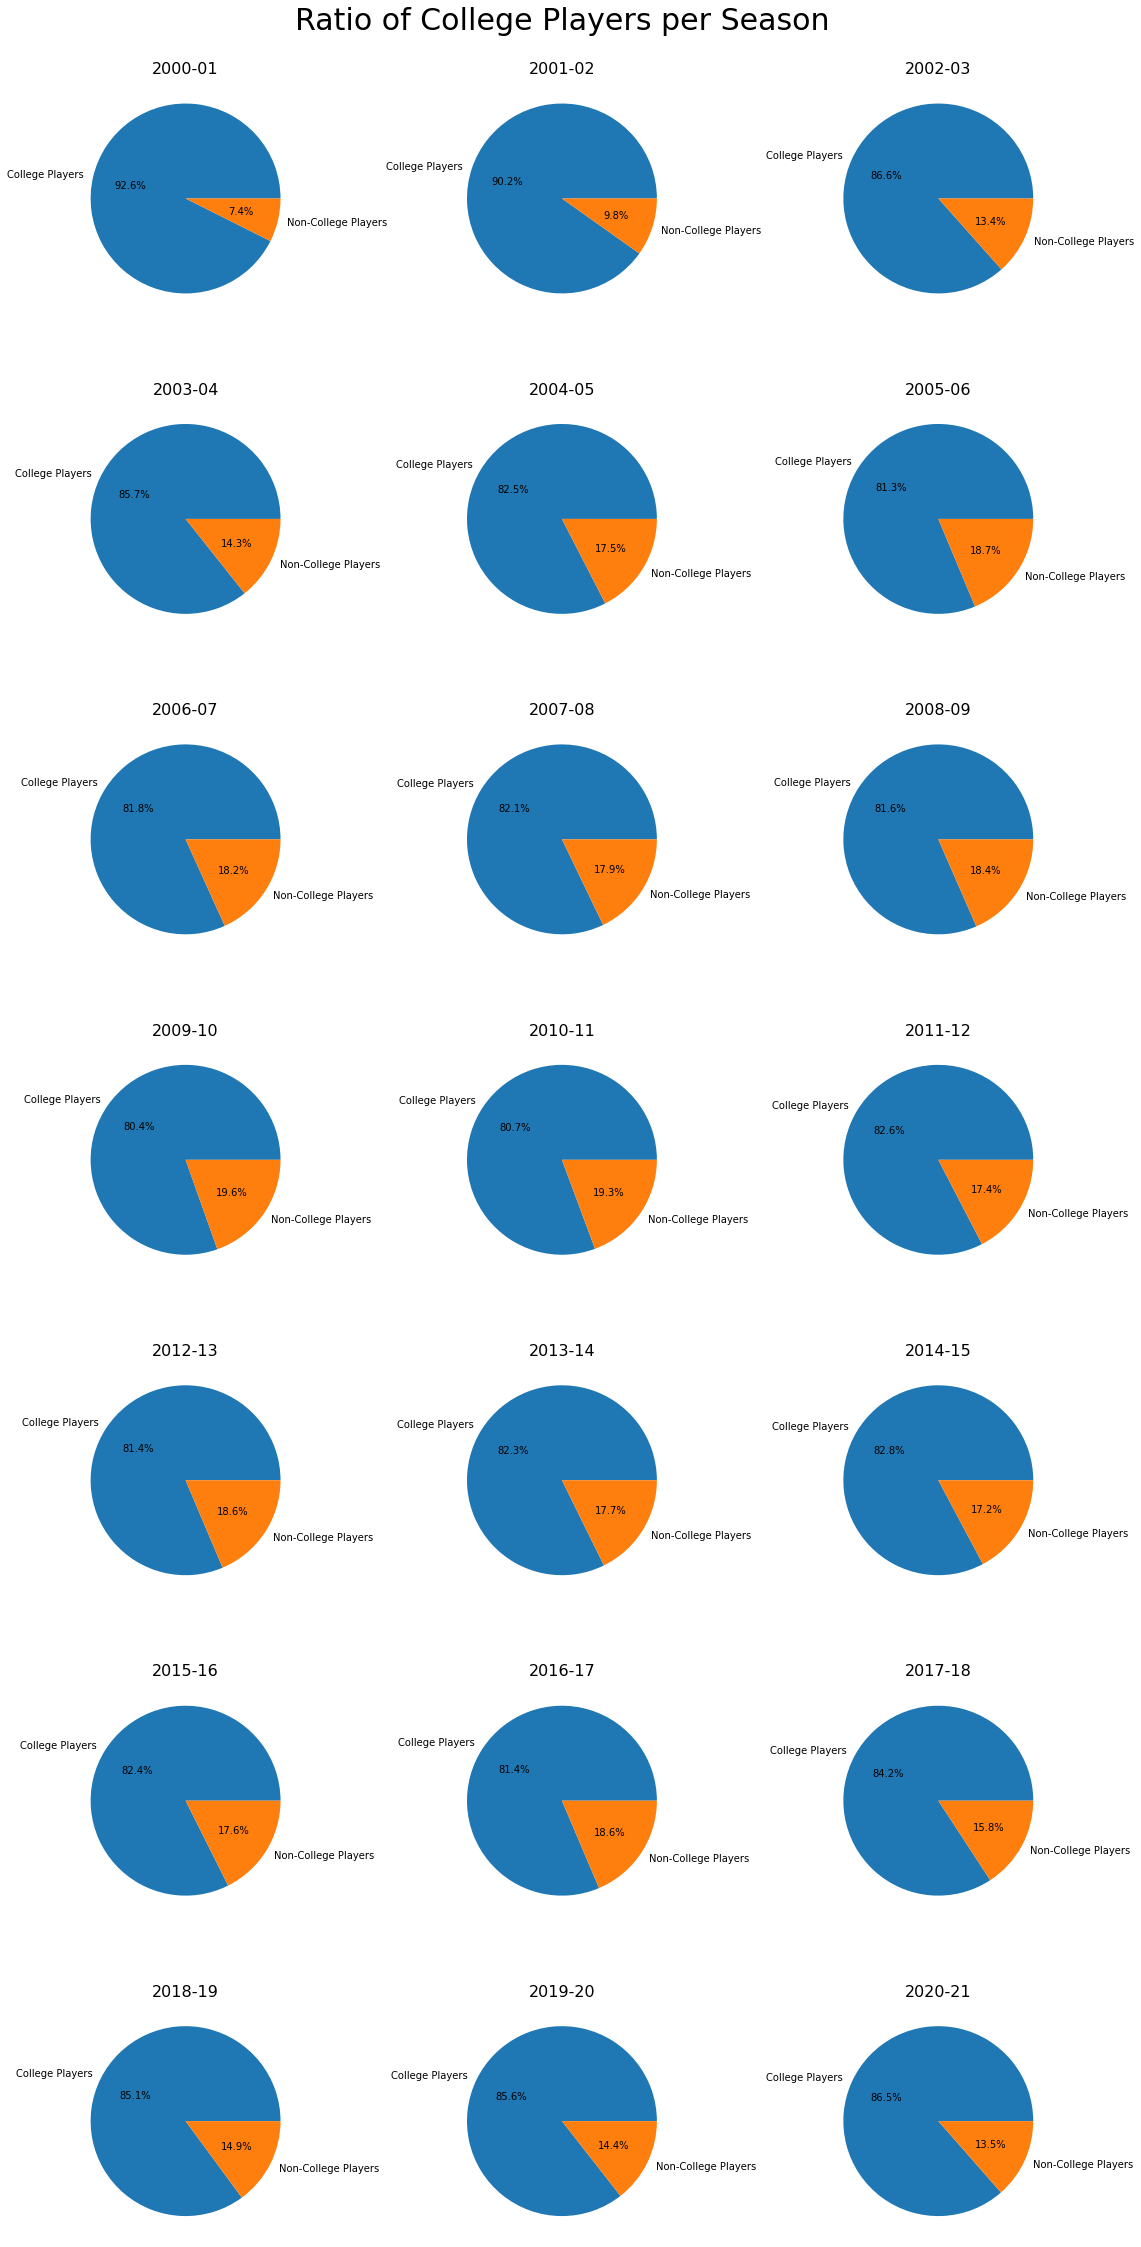

In [80]:
# Ratio of College Players per Season

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['SEASON'].unique())
num_cols = 3
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

# Plot pie-chart of college players per season
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Ratio of College Players per Season', fontsize=30, pad=50)

k = 0 # Position index

for season in seasons:
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    ax.set_title(season, fontsize=16)

    k += 1 # Update position index
    
    season_data = all_players[all_players['SEASON'] == season]
    num_non_college_players = len(season_data[season_data['COLLEGE'] == 'None'])
    num_college_players = len(season_data[season_data['COLLEGE'] != 'None'])

    plt.pie(
        x = [num_college_players, num_non_college_players],
        labels = ['College Players', 'Non-College Players'],
        normalize = True,
        autopct='%1.1f%%'
    )

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Ratio of College Players per Season')
plt.show()

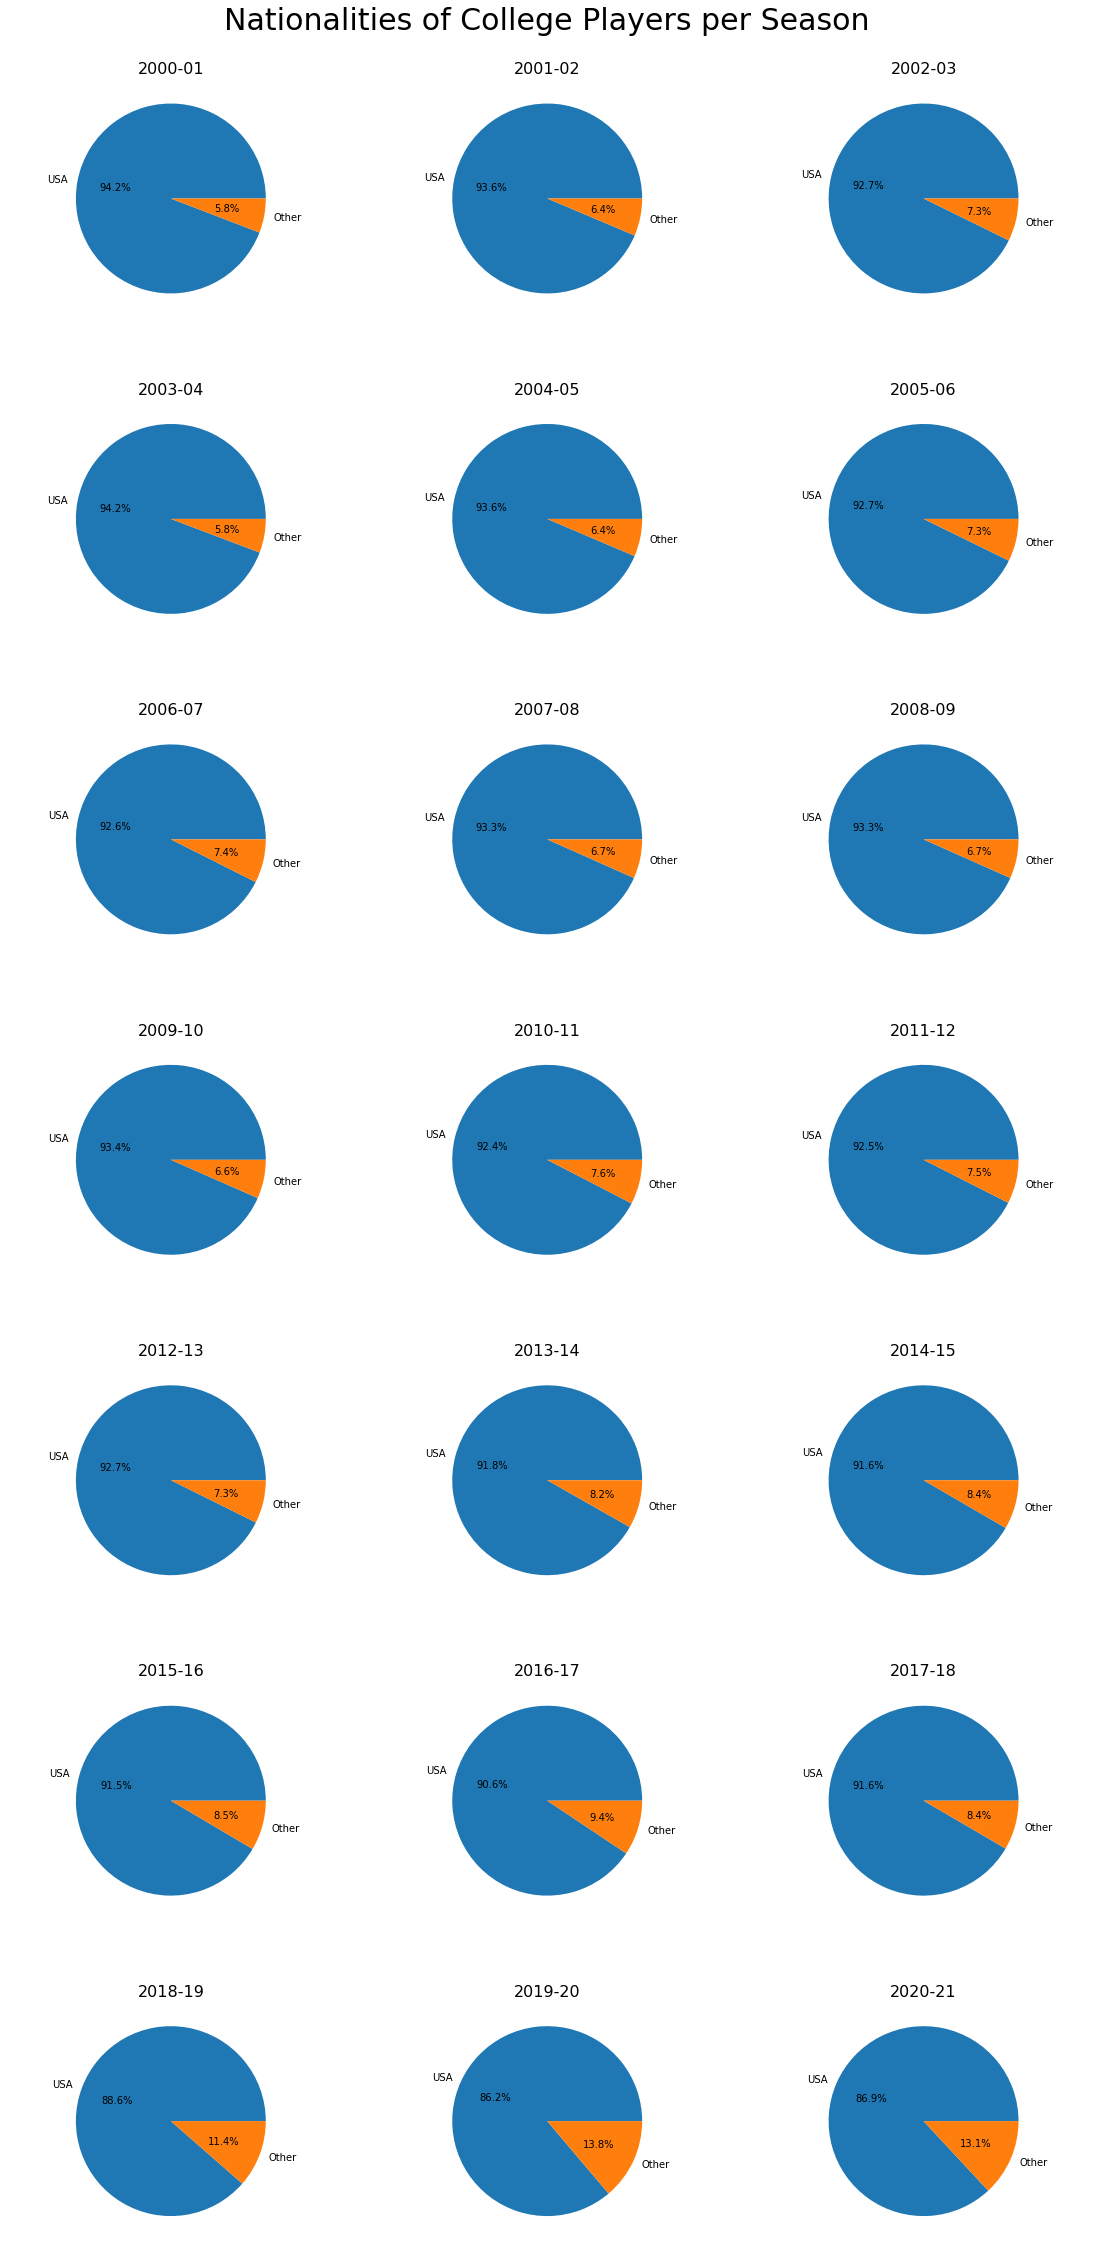

In [93]:
# Nationalities of College Players per Season

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['SEASON'].unique())
num_cols = 3
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

# Plot pie-chart of college players per season
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Nationalities of College Players per Season', fontsize=30, pad=50)

k = 0 # Position index

for season in seasons:
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    ax.set_title(season, fontsize=16)

    k += 1 # Update position index
    
    college_players = all_players[(all_players['SEASON'] == season) & (all_players['COLLEGE'] != 'None')]
    num_us_college_players = len(college_players[college_players['COUNTRY'] == 'USA'])

    plt.pie(
        x = [num_us_college_players, len(college_players) - num_us_college_players],
        labels = ['USA', 'Other'],
        normalize = True,
        autopct='%1.1f%%'
    )

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Nationalities of College Players per Season')
plt.show()

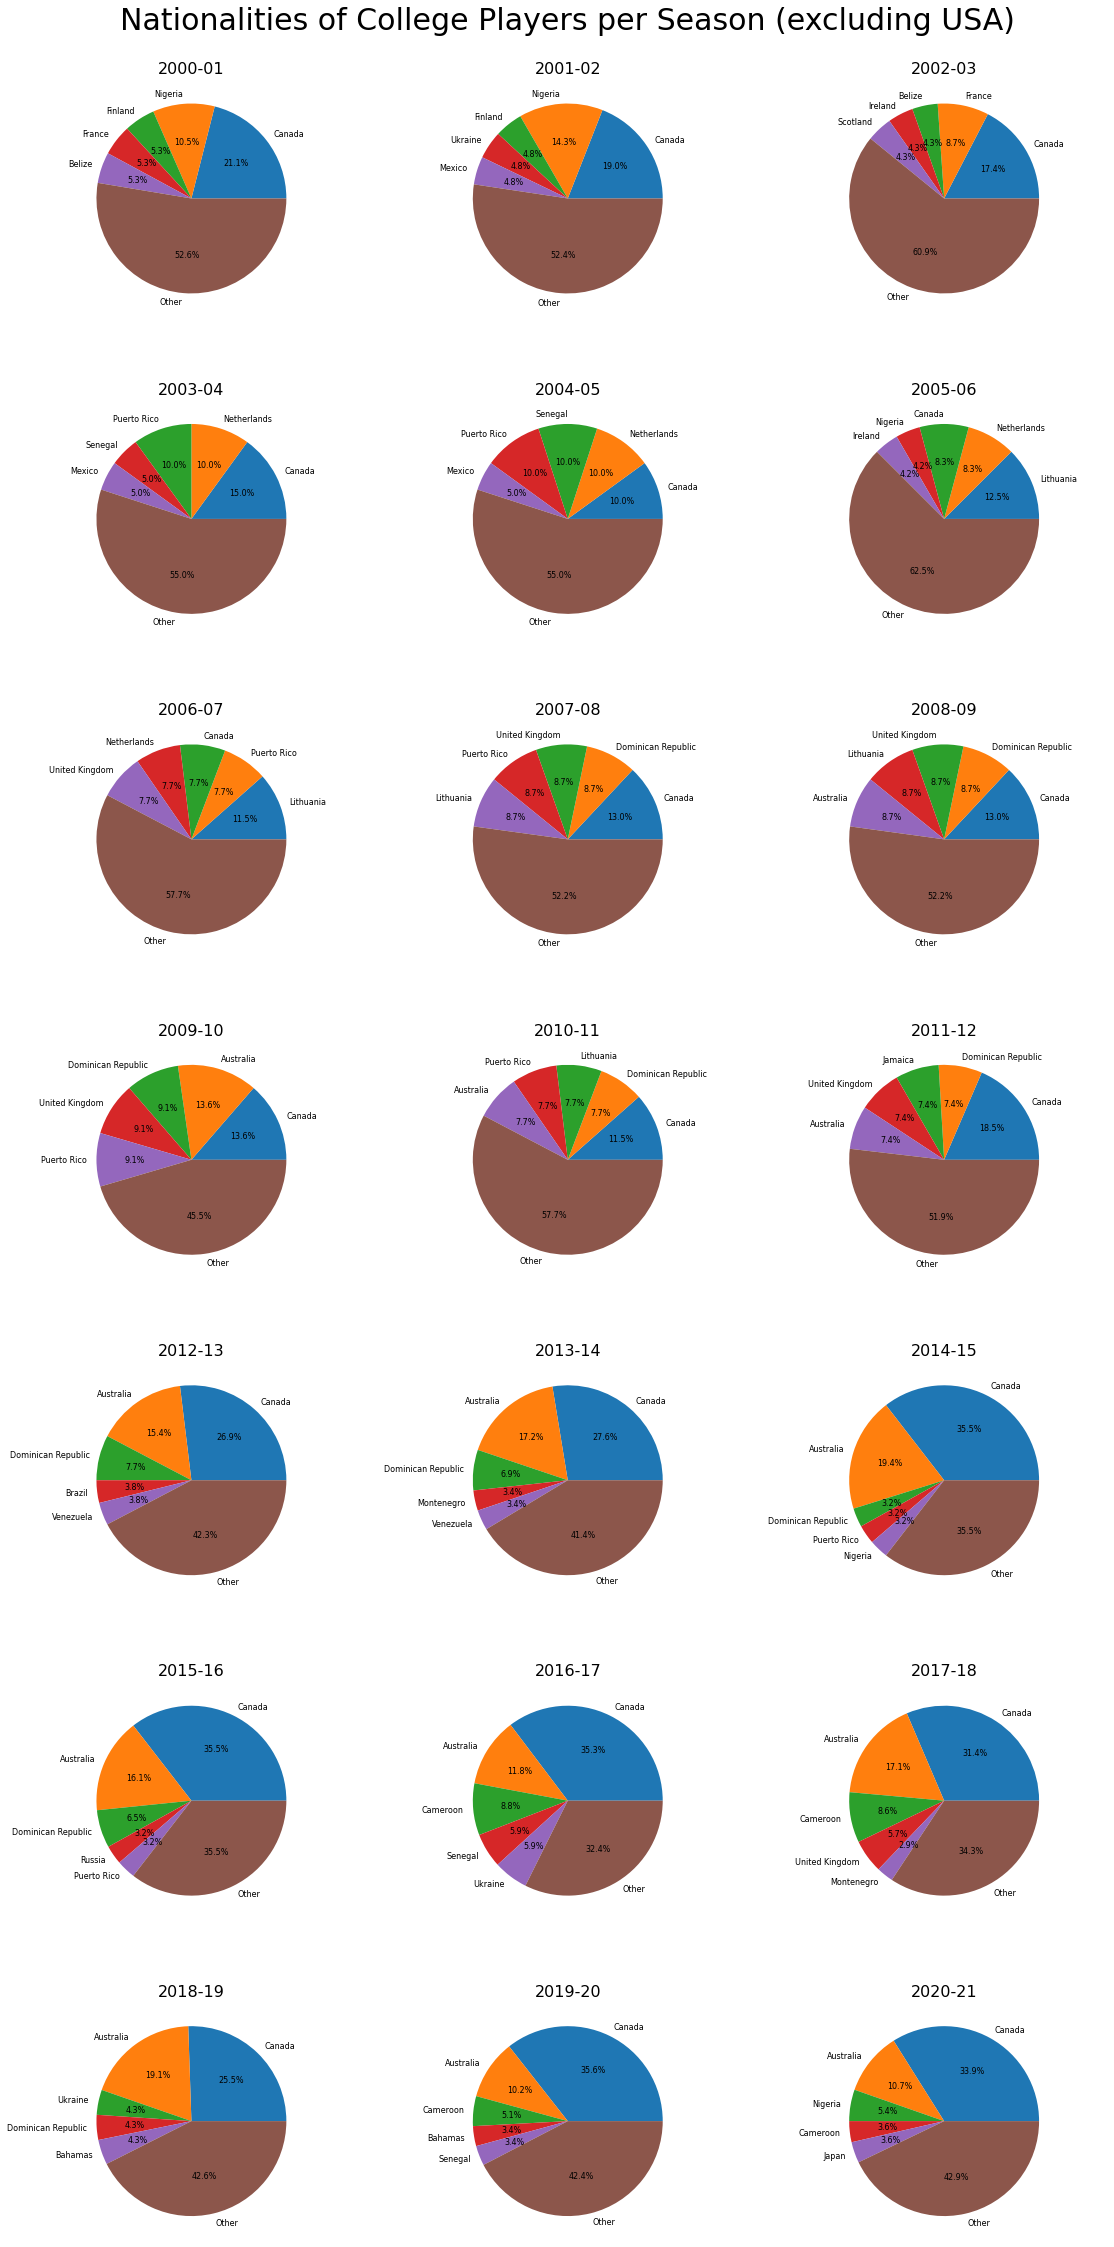

In [106]:
# Nationalities of College Players per Season (excluding USA)

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['SEASON'].unique())
num_cols = 3
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

# Plot pie-chart of college players per season
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Nationalities of College Players per Season (excluding USA)', fontsize=30, pad=50)

k = 0 # Position index

for season in seasons:
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    ax.set_title(season, fontsize=16)

    k += 1 # Update position index
    
    college_players = all_players[
        (all_players['SEASON'] == season) & (all_players['COLLEGE'] != 'None') & (all_players['COUNTRY'] != 'USA')
    ]

    top_5_nationalities = college_players['COUNTRY'].value_counts()[:5]

    plt.pie(
        x = list(top_5_nationalities) + [len(college_players) - top_5_nationalities.sum()],
        labels = [country for country in top_5_nationalities.index] + ['Other'],
        normalize = True,
        autopct ='%1.1f%%',
        textprops={'size':'8'}
    )

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Nationalities of College Players per Season (excluding USA)')
plt.show()

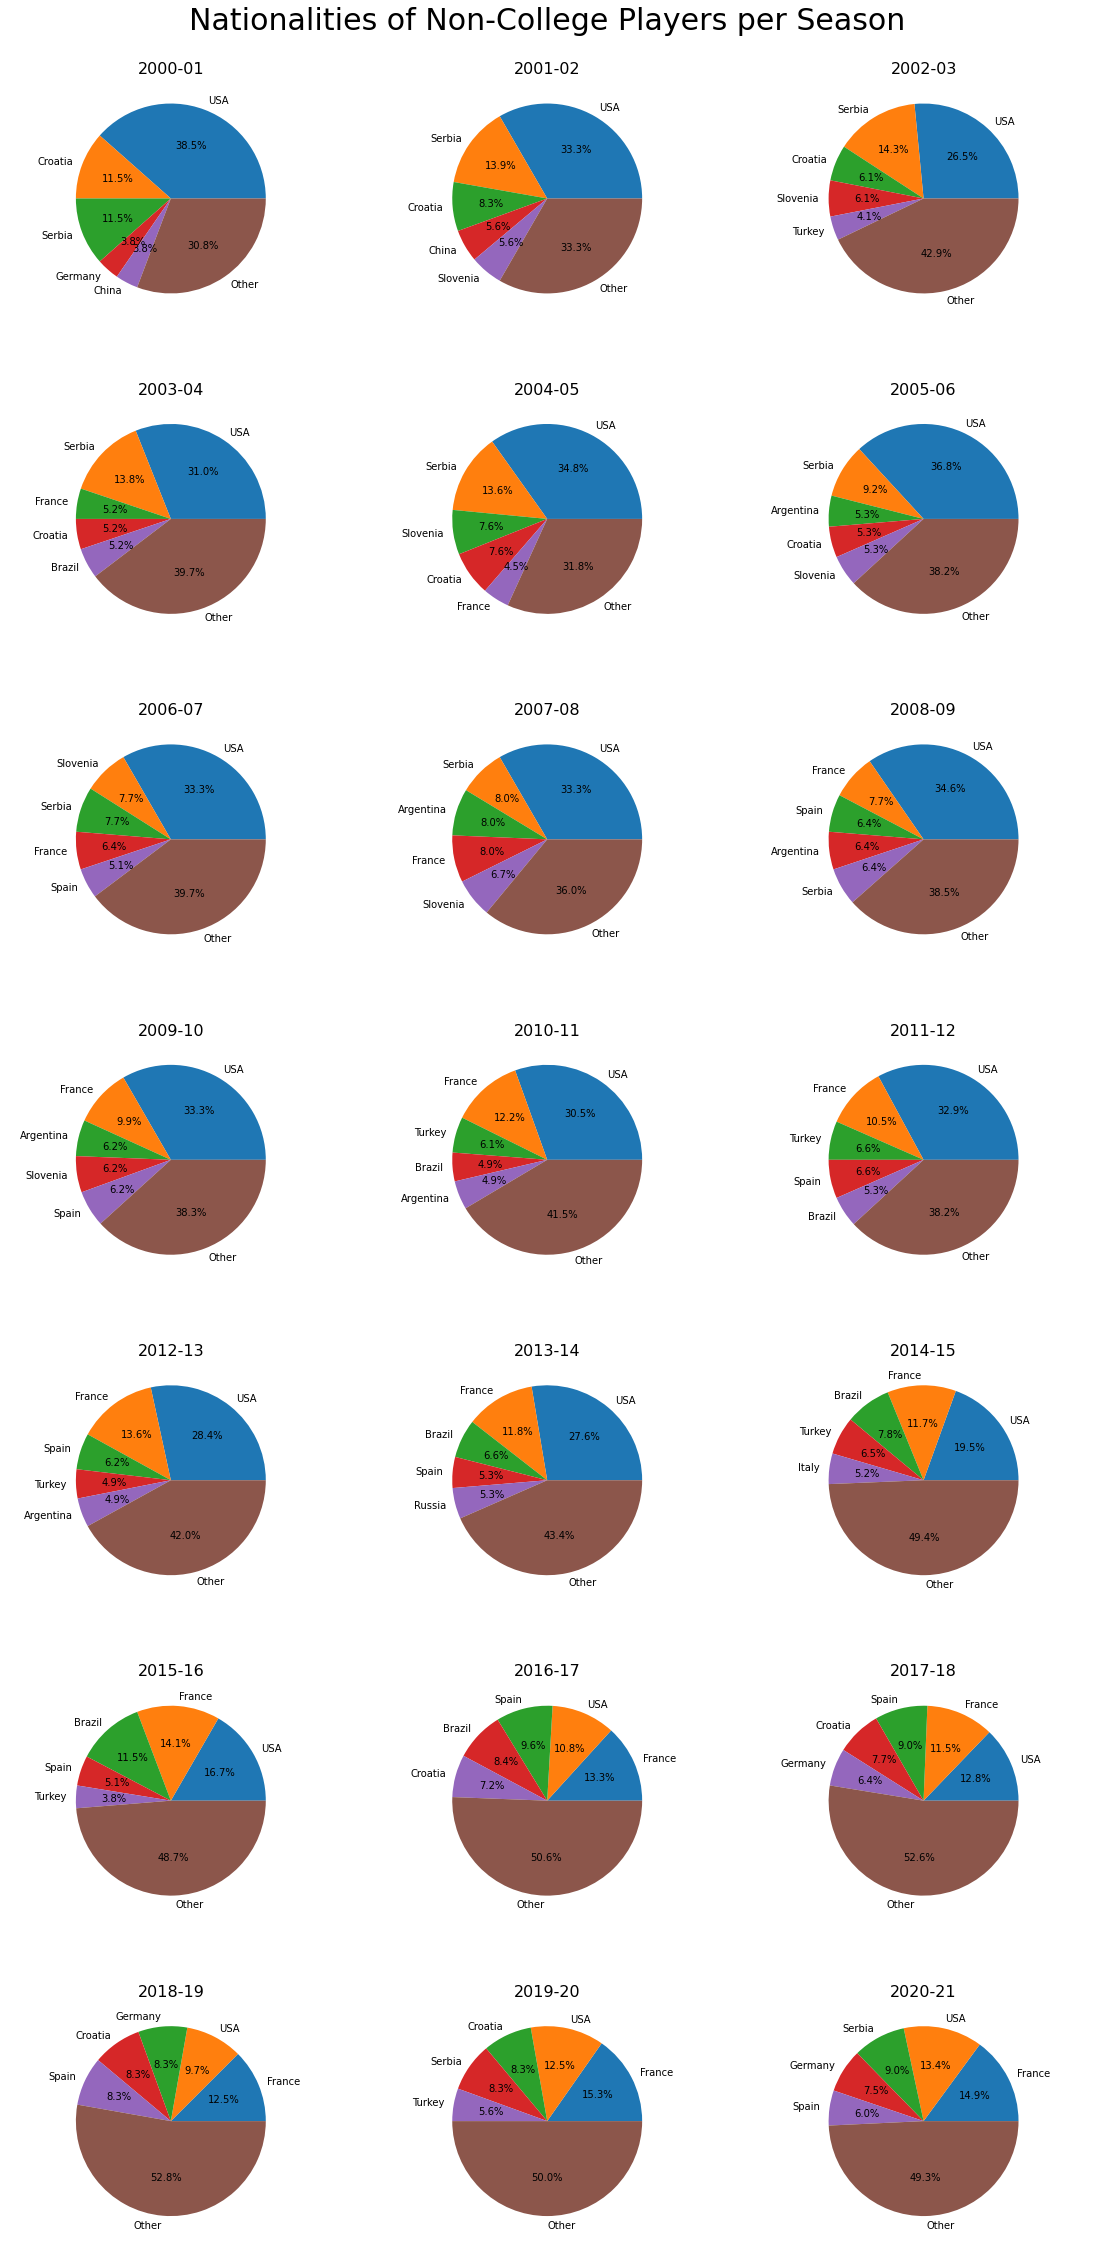

In [100]:
# Nationalities of Non-College Players per Season

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['SEASON'].unique())
num_cols = 3
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

# Plot pie-chart of college players per season
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Nationalities of Non-College Players per Season', fontsize=30, pad=50)

k = 0 # Position index

for season in seasons:
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    ax.set_title(season, fontsize=16)

    k += 1 # Update position index
    
    non_college_players = all_players[(all_players['SEASON'] == season) & (all_players['COLLEGE'] == 'None')]
    top_5_nationalities = non_college_players['COUNTRY'].value_counts()[:5]

    plt.pie(
        x = list(top_5_nationalities) + [len(non_college_players) - top_5_nationalities.sum()],
        labels = [country for country in top_5_nationalities.index] + ['Other'],
        normalize = True,
        autopct='%1.1f%%'
    )

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Nationalities of Non-College Players per Season')
plt.show()

# Country

In [109]:
all_players[all_players['SEASON'] == season]['COUNTRY'].value_counts()[:6]

USA          381
Canada        19
France        12
Australia      8
Serbia         6
Germany        6
Name: COUNTRY, dtype: int64

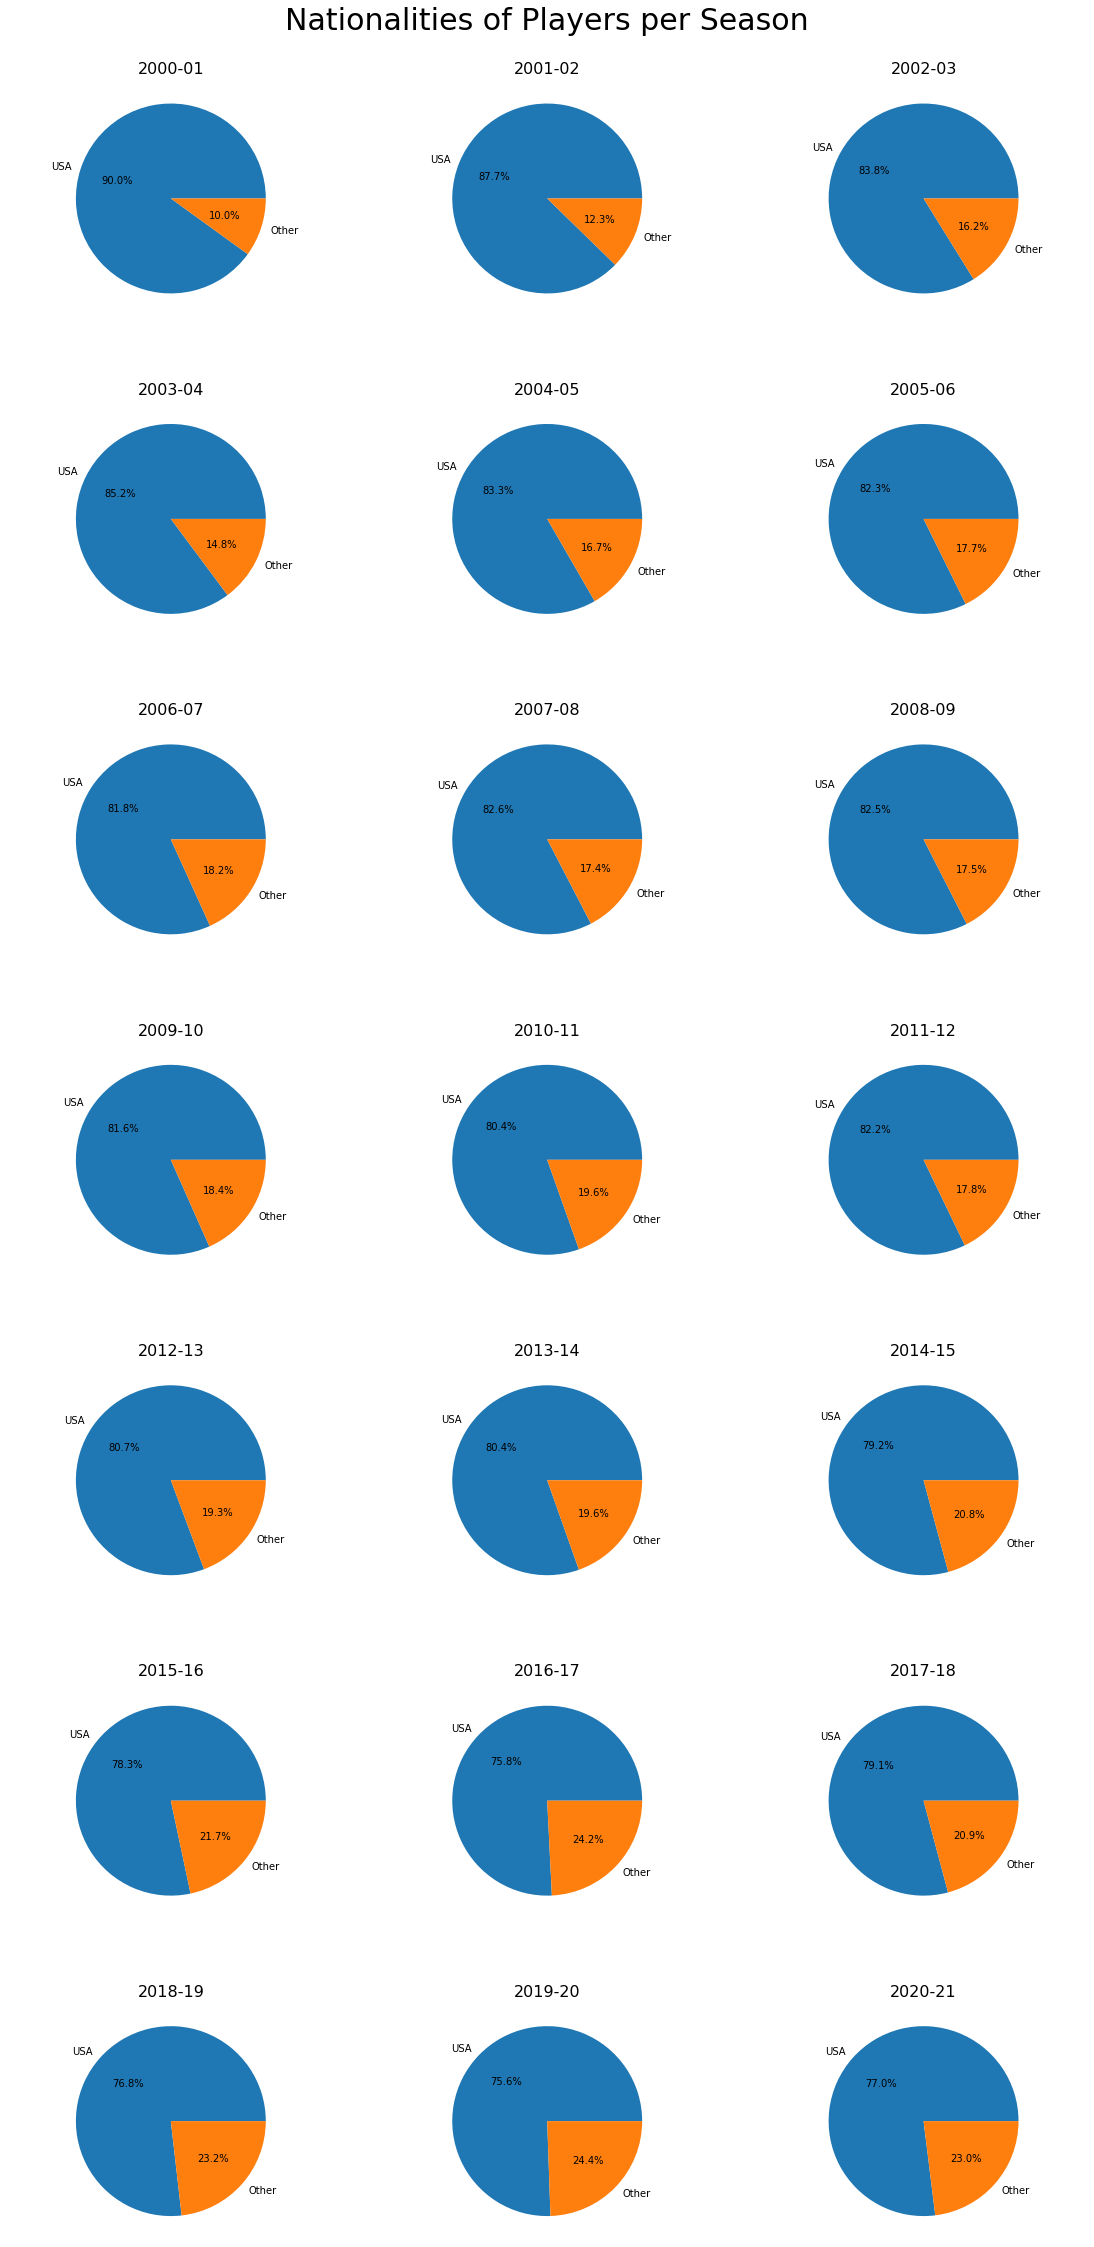

In [113]:
# Nationalities of Players per Season

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['SEASON'].unique())
num_cols = 3
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

# Plot pie-chart of college players per season
fig = plt.figure(figsize=(25,50))
plt.axis('off')
plt.title('Nationalities of Players per Season', fontsize=30, pad=50)

k = 0 # Position index

for season in seasons:
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    ax.set_title(season, fontsize=16)

    k += 1 # Update position index
    
    num_american_players = len(all_players[(all_players['SEASON'] == season) & (all_players['COUNTRY'] == 'USA')])

    plt.pie(
        x = [num_american_players, len(all_players[all_players['SEASON'] == season]) - num_american_players],
        labels = ['USA', 'Other'],
        normalize = True,
        autopct = '%1.1f%%'
    )

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Nationalities of Players per Season')
plt.show()

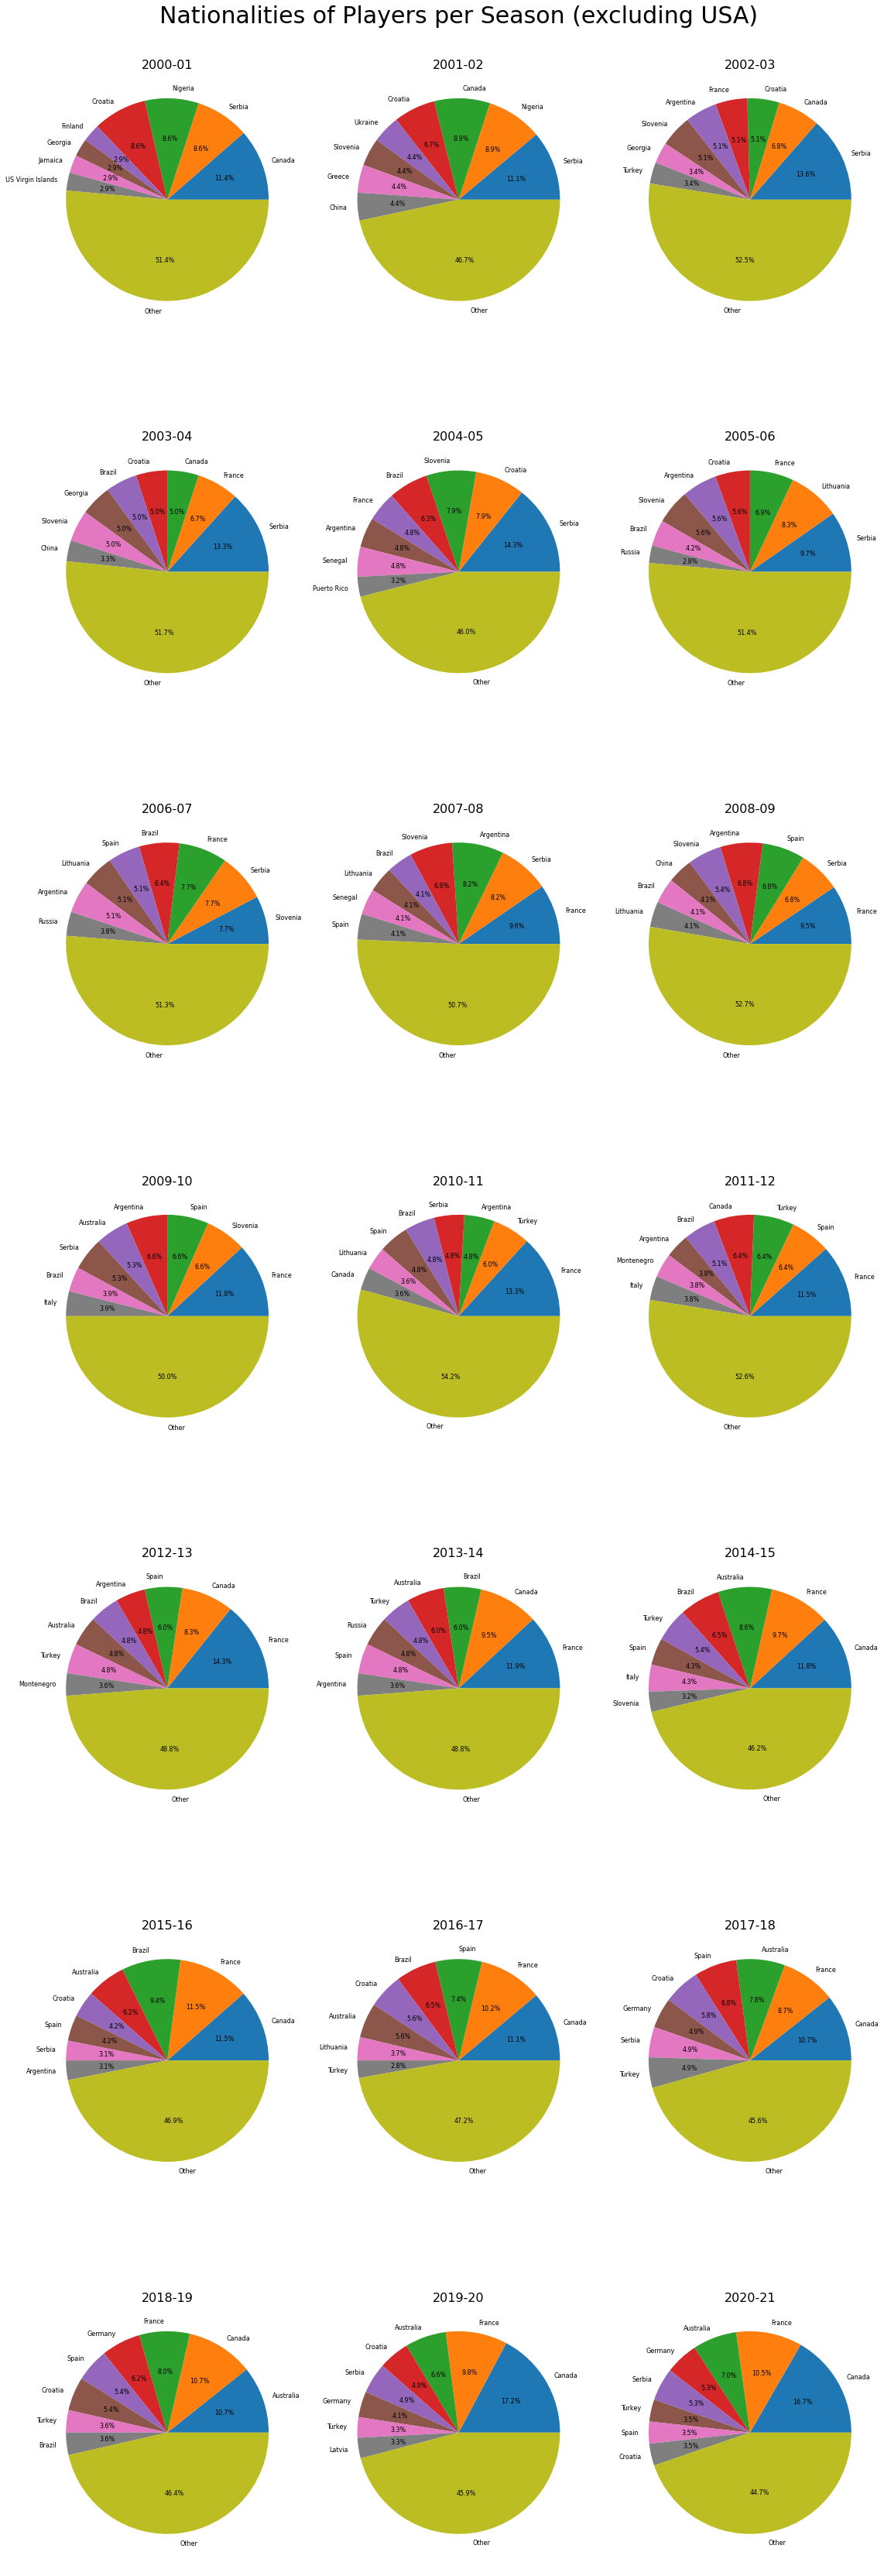

In [122]:
# Nationalities of Players per Season (excluding USA)

# Dynamically draw subplots
# https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib 
num_subplots = len(all_players['SEASON'].unique())
num_cols = 3
num_rows = (num_subplots // num_cols) + (num_subplots % num_cols)
graph_position = range(1, num_subplots+1) # Create position index

# Plot pie-chart of college players per season (excluding USA)
fig = plt.figure(figsize=(25,75))
plt.axis('off')
plt.title('Nationalities of Players per Season (excluding USA)', fontsize=30, pad=50)

k = 0 # Position index

for season in seasons:
    ax = fig.add_subplot(num_rows, num_cols, graph_position[k])
    ax.set_title(season, fontsize=16)

    k += 1 # Update position index
    
    top_8_nationalities = all_players[
        (all_players['SEASON'] == season) & (all_players['COUNTRY'] != 'USA')
    ]['COUNTRY'].value_counts()[:8]

    plt.pie(
        x = list(top_8_nationalities) + [
            len(all_players[(all_players['SEASON'] == season) & (all_players['COUNTRY'] != 'USA')]) - top_8_nationalities.sum()
        ],
        labels = [country for country in top_8_nationalities.index] + ['Other'],
        normalize = True,
        autopct = '%1.1f%%',
        textprops = {'size': '8'}
    )

plt.subplots_adjust(left=0.2,
                    bottom=0.3, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.15, 
                    hspace=0.35)

# plt.tight_layout()
plt.savefig('./Graphs/Players/Nationalities of Players per Season (excluding USA)')
plt.show()